In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

np.random.seed(69)
torch.manual_seed(69)

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data

In [240]:
X_real = np.load('Data/data_without_nan_real.npy')
X_cat = np.load('Data/data_without_nan_cat.npy')
r_c = X_real.shape[1]

X = np.hstack([X_real, X_cat])
y = np.load('Data/y.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()

# X_train_r = scaler.fit_transform(X_train[:, :r_c])
# X_test_r = scaler.transform(X_test[:, :r_c])

# X_train = np.hstack([X_train_r, X_train[:, r_c:]])
# X_test = np.hstack([X_test_r, X_test[:, r_c:]])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [241]:
data = [X_train, X_test, y_train, y_test]

### Batch generator

In [242]:
class Batch(object):
    def __init__(self, train_size, test_size):
        self.train_indexes = np.arange(train_size)
        self.test_indexes = np.arange(test_size)
        
        self.pointer = 0
        
    def get_batch(self, size, mode='train'):
        if mode == 'train':
            indexes = self.train_indexes
        else:
            indexes = self.test_indexes
        
        if self.pointer + size <= len(indexes):
            index_subset = indexes[self.pointer:self.pointer + size]
            self.pointer += size
            if self.pointer >= len(indexes):
                self.pointer = 0
            return index_subset
        else:
            self.pointer = 0
            np.random.shuffle(self.train_indexes)
            return 'end'

In [269]:
class Flow(object):
    
    def __init__(self, name, model, data, lr, optimizer='SGD', batch_size=64):
        
        self.model = model
        self.name = name
        self.X_train, self.X_test, self.y_train, self.y_test = data
        self.batches = Batch(len(self.X_train), len(self.X_test))
        self.batch_size = batch_size
        
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
        if optimizer == 'SGD':
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        else:
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        
    def test(self):
        
        self.model.eval()
        
        target_npy = self.y_test
        target = torch.from_numpy(self.y_test).long().cuda()
        inputs = torch.from_numpy(self.X_test).float().cuda()
        outputs = self.model(inputs)
        
        loss = self.criterion(outputs, target)
        predictions = outputs[:, 1].detach().cpu().numpy()
        score = roc_auc_score(target_npy, predictions)
        
        return loss.item(), score
        
        
    def train_iter(self, inputs, target):
        
        output = self.model(inputs)
        loss = self.criterion(output, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self):
        
        self.model.train()
        self.batches.pointer = 0
        batch_losses = []
        while True:
            train_indexes = self.batches.get_batch(self.batch_size)
            if train_indexes == 'end':
                break
            inputs = self.X_train[train_indexes]
            target_npy = self.y_train[train_indexes]
            inputs = torch.from_numpy(inputs).float().cuda()
            target = torch.from_numpy(target_npy).long().cuda()
            batch_loss = self.train_iter(inputs, target)
            batch_losses.append(batch_loss)
        
        epoch_loss = sum(batch_losses)
        return epoch_loss
    
    def save_model(self):
        torch.save(self.model.state_dict(), self.name+'.trch')
        return 0

In [270]:
class MLP(nn.Module):
    def __init__(self, feature_size):
        super(MLP, self).__init__()
        self.sq_ = nn.Sequential(
            nn.Linear(feature_size, 32),
            nn.Tanh(),
            
            nn.Linear(32, 16),
            nn.Sigmoid(),
            
            nn.Linear(16, 8),
            nn.Sigmoid(),
            
            nn.Linear(8, 8),
            nn.Sigmoid(),
            
            nn.Linear(8, 4),
            nn.Sigmoid(),
            
            nn.Linear(4, 2)
        )
      
    def forward(self, x):
        
        output = self.sq_(x)
        
        return output

In [278]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
        
net = MLP(X_train.shape[1]).cuda()
net.apply(init_weights)

MLP(
  (sq_): Sequential(
    (0): Linear(in_features=628, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=8, out_features=4, bias=True)
    (9): Sigmoid()
    (10): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [279]:
flow = Flow('smart_regression', net, data, 2e-3, 'SGD')

In [280]:
best_score = 0

for epoch in range(40000):
    test_loss, test_score = flow.test()
    epoch_loss = flow.train()
    
    if test_score > best_score:
        flow.save_model()
        best_score = test_score
    print (epoch, ':', round(epoch_loss,3), round(test_loss,3), round(test_score,3))

0 : 9.888 0.779 0.535
1 : 9.795 0.775 0.536
2 : 9.768 0.77 0.535
3 : 9.713 0.766 0.534
4 : 9.651 0.762 0.535
5 : 9.638 0.758 0.534
6 : 9.61 0.755 0.534
7 : 9.563 0.751 0.535
8 : 9.519 0.747 0.534
9 : 9.507 0.744 0.534
10 : 9.47 0.741 0.535
11 : 9.419 0.738 0.535
12 : 9.409 0.735 0.535
13 : 9.373 0.732 0.535
14 : 9.34 0.729 0.534
15 : 9.318 0.727 0.534
16 : 9.304 0.724 0.534
17 : 9.262 0.722 0.534
18 : 9.236 0.719 0.533
19 : 9.221 0.717 0.533
20 : 9.209 0.715 0.533
21 : 9.198 0.713 0.533
22 : 9.171 0.711 0.533
23 : 9.152 0.709 0.533
24 : 9.136 0.707 0.533
25 : 9.114 0.705 0.533
26 : 9.096 0.704 0.533
27 : 9.086 0.702 0.533
28 : 9.068 0.7 0.533
29 : 9.055 0.699 0.533
30 : 9.044 0.697 0.533
31 : 9.028 0.696 0.534
32 : 9.016 0.694 0.533
33 : 9.003 0.693 0.533
34 : 8.992 0.692 0.534
35 : 8.982 0.69 0.534
36 : 8.972 0.689 0.534
37 : 8.965 0.688 0.535
38 : 8.954 0.687 0.535
39 : 8.943 0.686 0.535
40 : 8.936 0.685 0.535
41 : 8.924 0.684 0.535
42 : 8.919 0.683 0.534
43 : 8.907 0.682 0.534
44 : 

358 : 8.766 0.652 0.576
359 : 8.654 0.652 0.576
360 : 8.686 0.652 0.576
361 : 8.673 0.652 0.576
362 : 8.753 0.652 0.577
363 : 8.752 0.652 0.577
364 : 8.739 0.652 0.577
365 : 8.712 0.652 0.577
366 : 8.719 0.652 0.578
367 : 8.739 0.652 0.578
368 : 8.693 0.652 0.578
369 : 8.72 0.652 0.578
370 : 8.713 0.652 0.578
371 : 8.719 0.652 0.578
372 : 8.706 0.652 0.578
373 : 8.699 0.652 0.579
374 : 8.706 0.652 0.579
375 : 8.733 0.652 0.579
376 : 8.719 0.652 0.579
377 : 8.726 0.652 0.58
378 : 8.706 0.652 0.58
379 : 8.719 0.652 0.58
380 : 8.726 0.652 0.58
381 : 8.679 0.652 0.58
382 : 8.732 0.652 0.58
383 : 8.719 0.652 0.58
384 : 8.712 0.652 0.58
385 : 8.726 0.652 0.581
386 : 8.693 0.652 0.581
387 : 8.7 0.652 0.581
388 : 8.739 0.652 0.581
389 : 8.706 0.652 0.581
390 : 8.746 0.652 0.582
391 : 8.706 0.652 0.582
392 : 8.739 0.652 0.582
393 : 8.726 0.652 0.582
394 : 8.739 0.652 0.582
395 : 8.719 0.652 0.583
396 : 8.719 0.652 0.583
397 : 8.68 0.652 0.583
398 : 8.686 0.652 0.583
399 : 8.705 0.652 0.584
400 

708 : 8.717 0.652 0.623
709 : 8.709 0.652 0.623
710 : 8.69 0.652 0.624
711 : 8.722 0.652 0.624
712 : 8.703 0.652 0.624
713 : 8.736 0.652 0.624
714 : 8.742 0.652 0.624
715 : 8.709 0.652 0.625
716 : 8.736 0.652 0.625
717 : 8.729 0.652 0.624
718 : 8.736 0.652 0.624
719 : 8.716 0.652 0.624
720 : 8.729 0.652 0.625
721 : 8.742 0.652 0.625
722 : 8.715 0.652 0.625
723 : 8.696 0.652 0.625
724 : 8.723 0.652 0.625
725 : 8.736 0.652 0.625
726 : 8.676 0.652 0.626
727 : 8.742 0.652 0.626
728 : 8.729 0.652 0.626
729 : 8.722 0.652 0.626
730 : 8.755 0.652 0.626
731 : 8.735 0.652 0.626
732 : 8.677 0.652 0.626
733 : 8.722 0.652 0.626
734 : 8.709 0.652 0.626
735 : 8.677 0.652 0.626
736 : 8.729 0.652 0.626
737 : 8.735 0.652 0.627
738 : 8.775 0.652 0.627
739 : 8.71 0.652 0.627
740 : 8.71 0.652 0.627
741 : 8.755 0.652 0.627
742 : 8.729 0.652 0.627
743 : 8.762 0.652 0.627
744 : 8.722 0.652 0.627
745 : 8.723 0.652 0.627
746 : 8.703 0.652 0.627
747 : 8.716 0.652 0.628
748 : 8.716 0.652 0.628
749 : 8.762 0.652 0

1055 : 8.739 0.652 0.659
1056 : 8.726 0.652 0.659
1057 : 8.752 0.652 0.659
1058 : 8.726 0.652 0.659
1059 : 8.693 0.652 0.659
1060 : 8.72 0.652 0.659
1061 : 8.673 0.652 0.659
1062 : 8.745 0.652 0.659
1063 : 8.745 0.652 0.659
1064 : 8.693 0.652 0.659
1065 : 8.732 0.652 0.659
1066 : 8.713 0.652 0.659
1067 : 8.739 0.652 0.659
1068 : 8.726 0.652 0.659
1069 : 8.706 0.652 0.659
1070 : 8.673 0.652 0.659
1071 : 8.719 0.652 0.66
1072 : 8.719 0.652 0.66
1073 : 8.686 0.652 0.66
1074 : 8.699 0.652 0.66
1075 : 8.706 0.652 0.66
1076 : 8.726 0.652 0.66
1077 : 8.673 0.652 0.66
1078 : 8.759 0.652 0.66
1079 : 8.739 0.652 0.66
1080 : 8.732 0.652 0.66
1081 : 8.719 0.652 0.66
1082 : 8.706 0.652 0.66
1083 : 8.712 0.652 0.66
1084 : 8.725 0.652 0.66
1085 : 8.738 0.652 0.66
1086 : 8.725 0.652 0.661
1087 : 8.752 0.652 0.661
1088 : 8.719 0.652 0.661
1089 : 8.719 0.652 0.661
1090 : 8.719 0.652 0.661
1091 : 8.732 0.652 0.661
1092 : 8.719 0.652 0.661
1093 : 8.686 0.652 0.661
1094 : 8.706 0.652 0.661
1095 : 8.692 0.6

1390 : 8.702 0.652 0.685
1391 : 8.696 0.652 0.685
1392 : 8.742 0.652 0.685
1393 : 8.702 0.652 0.685
1394 : 8.709 0.652 0.685
1395 : 8.709 0.652 0.685
1396 : 8.722 0.652 0.685
1397 : 8.689 0.652 0.685
1398 : 8.696 0.652 0.685
1399 : 8.695 0.651 0.685
1400 : 8.71 0.651 0.685
1401 : 8.762 0.651 0.685
1402 : 8.682 0.652 0.685
1403 : 8.722 0.652 0.685
1404 : 8.715 0.652 0.686
1405 : 8.689 0.652 0.686
1406 : 8.696 0.651 0.686
1407 : 8.723 0.651 0.686
1408 : 8.709 0.651 0.686
1409 : 8.735 0.651 0.686
1410 : 8.715 0.652 0.686
1411 : 8.709 0.652 0.686
1412 : 8.715 0.652 0.686
1413 : 8.722 0.652 0.686
1414 : 8.709 0.652 0.686
1415 : 8.683 0.652 0.686
1416 : 8.741 0.651 0.686
1417 : 8.696 0.652 0.686
1418 : 8.682 0.652 0.687
1419 : 8.709 0.651 0.687
1420 : 8.729 0.651 0.687
1421 : 8.675 0.651 0.687
1422 : 8.669 0.651 0.687
1423 : 8.735 0.651 0.687
1424 : 8.715 0.651 0.687
1425 : 8.708 0.651 0.687
1426 : 8.741 0.651 0.687
1427 : 8.721 0.651 0.687
1428 : 8.715 0.651 0.687
1429 : 8.702 0.651 0.687
1

1722 : 8.763 0.651 0.708
1723 : 8.672 0.651 0.708
1724 : 8.712 0.651 0.708
1725 : 8.718 0.651 0.708
1726 : 8.711 0.651 0.708
1727 : 8.731 0.651 0.708
1728 : 8.678 0.651 0.708
1729 : 8.744 0.651 0.708
1730 : 8.725 0.651 0.708
1731 : 8.75 0.651 0.708
1732 : 8.691 0.651 0.709
1733 : 8.704 0.651 0.708
1734 : 8.698 0.651 0.709
1735 : 8.711 0.651 0.709
1736 : 8.711 0.651 0.709
1737 : 8.711 0.651 0.709
1738 : 8.711 0.651 0.709
1739 : 8.738 0.651 0.709
1740 : 8.691 0.651 0.709
1741 : 8.705 0.651 0.709
1742 : 8.718 0.651 0.709
1743 : 8.705 0.651 0.709
1744 : 8.724 0.651 0.709
1745 : 8.724 0.651 0.709
1746 : 8.698 0.651 0.709
1747 : 8.698 0.651 0.709
1748 : 8.717 0.651 0.709
1749 : 8.712 0.651 0.709
1750 : 8.724 0.651 0.709
1751 : 8.692 0.651 0.709
1752 : 8.724 0.651 0.709
1753 : 8.737 0.651 0.709
1754 : 8.704 0.651 0.71
1755 : 8.73 0.651 0.71
1756 : 8.723 0.651 0.71
1757 : 8.711 0.651 0.71
1758 : 8.723 0.651 0.71
1759 : 8.743 0.651 0.71
1760 : 8.704 0.651 0.71
1761 : 8.757 0.651 0.71
1762 : 8.7

2059 : 8.68 0.651 0.727
2060 : 8.674 0.651 0.727
2061 : 8.7 0.651 0.727
2062 : 8.706 0.651 0.727
2063 : 8.74 0.651 0.727
2064 : 8.726 0.651 0.727
2065 : 8.66 0.651 0.727
2066 : 8.712 0.651 0.727
2067 : 8.706 0.651 0.727
2068 : 8.692 0.651 0.728
2069 : 8.74 0.651 0.728
2070 : 8.686 0.651 0.728
2071 : 8.725 0.651 0.728
2072 : 8.733 0.651 0.728
2073 : 8.687 0.651 0.728
2074 : 8.706 0.651 0.728
2075 : 8.712 0.651 0.728
2076 : 8.693 0.651 0.728
2077 : 8.739 0.651 0.728
2078 : 8.674 0.651 0.728
2079 : 8.713 0.651 0.728
2080 : 8.693 0.651 0.728
2081 : 8.713 0.651 0.728
2082 : 8.686 0.651 0.728
2083 : 8.68 0.651 0.728
2084 : 8.733 0.651 0.728
2085 : 8.693 0.651 0.728
2086 : 8.725 0.651 0.728
2087 : 8.705 0.651 0.728
2088 : 8.673 0.651 0.728
2089 : 8.725 0.651 0.729
2090 : 8.706 0.651 0.729
2091 : 8.686 0.651 0.729
2092 : 8.718 0.651 0.729
2093 : 8.712 0.651 0.729
2094 : 8.699 0.651 0.729
2095 : 8.693 0.651 0.729
2096 : 8.692 0.651 0.729
2097 : 8.699 0.651 0.729
2098 : 8.726 0.651 0.729
2099 : 

2389 : 8.694 0.651 0.743
2390 : 8.707 0.651 0.743
2391 : 8.668 0.651 0.743
2392 : 8.701 0.651 0.744
2393 : 8.714 0.651 0.744
2394 : 8.688 0.651 0.744
2395 : 8.7 0.651 0.744
2396 : 8.727 0.651 0.744
2397 : 8.707 0.651 0.744
2398 : 8.714 0.651 0.744
2399 : 8.681 0.651 0.744
2400 : 8.713 0.651 0.744
2401 : 8.713 0.651 0.744
2402 : 8.721 0.651 0.744
2403 : 8.668 0.651 0.744
2404 : 8.708 0.651 0.744
2405 : 8.681 0.651 0.744
2406 : 8.688 0.651 0.744
2407 : 8.727 0.651 0.744
2408 : 8.707 0.651 0.744
2409 : 8.72 0.651 0.744
2410 : 8.687 0.651 0.744
2411 : 8.719 0.651 0.744
2412 : 8.668 0.651 0.745
2413 : 8.668 0.651 0.745
2414 : 8.7 0.651 0.745
2415 : 8.654 0.651 0.745
2416 : 8.719 0.651 0.745
2417 : 8.7 0.651 0.745
2418 : 8.687 0.651 0.745
2419 : 8.687 0.651 0.745
2420 : 8.707 0.651 0.745
2421 : 8.674 0.651 0.745
2422 : 8.687 0.651 0.745
2423 : 8.726 0.651 0.745
2424 : 8.7 0.651 0.745
2425 : 8.693 0.651 0.745
2426 : 8.7 0.651 0.745
2427 : 8.733 0.651 0.745
2428 : 8.662 0.651 0.745
2429 : 8.66

2730 : 8.7 0.65 0.756
2731 : 8.727 0.65 0.756
2732 : 8.68 0.65 0.756
2733 : 8.707 0.65 0.756
2734 : 8.681 0.65 0.756
2735 : 8.681 0.65 0.756
2736 : 8.688 0.65 0.756
2737 : 8.655 0.65 0.756
2738 : 8.733 0.65 0.756
2739 : 8.701 0.65 0.756
2740 : 8.713 0.65 0.757
2741 : 8.713 0.65 0.757
2742 : 8.694 0.65 0.757
2743 : 8.668 0.65 0.757
2744 : 8.7 0.65 0.757
2745 : 8.673 0.65 0.757
2746 : 8.687 0.65 0.757
2747 : 8.688 0.65 0.757
2748 : 8.72 0.65 0.757
2749 : 8.673 0.65 0.757
2750 : 8.693 0.65 0.757
2751 : 8.661 0.65 0.757
2752 : 8.693 0.65 0.757
2753 : 8.7 0.65 0.757
2754 : 8.726 0.65 0.757
2755 : 8.726 0.65 0.757
2756 : 8.699 0.65 0.757
2757 : 8.706 0.65 0.757
2758 : 8.7 0.65 0.757
2759 : 8.673 0.65 0.757
2760 : 8.706 0.65 0.757
2761 : 8.673 0.65 0.757
2762 : 8.706 0.65 0.757
2763 : 8.712 0.65 0.757
2764 : 8.698 0.65 0.757
2765 : 8.68 0.65 0.757
2766 : 8.641 0.65 0.757
2767 : 8.667 0.65 0.757
2768 : 8.705 0.65 0.757
2769 : 8.692 0.65 0.757
2770 : 8.699 0.65 0.757
2771 : 8.674 0.65 0.757
277

3082 : 8.705 0.65 0.764
3083 : 8.685 0.65 0.764
3084 : 8.71 0.65 0.764
3085 : 8.692 0.65 0.764
3086 : 8.679 0.65 0.764
3087 : 8.691 0.65 0.764
3088 : 8.696 0.65 0.764
3089 : 8.686 0.65 0.764
3090 : 8.697 0.65 0.764
3091 : 8.717 0.65 0.764
3092 : 8.685 0.65 0.764
3093 : 8.69 0.65 0.764
3094 : 8.686 0.65 0.764
3095 : 8.685 0.65 0.764
3096 : 8.697 0.65 0.764
3097 : 8.698 0.65 0.765
3098 : 8.69 0.65 0.765
3099 : 8.684 0.65 0.765
3100 : 8.69 0.65 0.765
3101 : 8.658 0.65 0.765
3102 : 8.692 0.65 0.765
3103 : 8.677 0.65 0.765
3104 : 8.676 0.65 0.765
3105 : 8.652 0.65 0.765
3106 : 8.696 0.65 0.765
3107 : 8.659 0.65 0.765
3108 : 8.685 0.65 0.765
3109 : 8.672 0.65 0.765
3110 : 8.657 0.65 0.766
3111 : 8.657 0.65 0.766
3112 : 8.659 0.65 0.766
3113 : 8.672 0.65 0.766
3114 : 8.658 0.65 0.766
3115 : 8.69 0.65 0.766
3116 : 8.71 0.65 0.766
3117 : 8.65 0.65 0.766
3118 : 8.69 0.65 0.766
3119 : 8.671 0.65 0.766
3120 : 8.703 0.65 0.766
3121 : 8.669 0.65 0.766
3122 : 8.704 0.65 0.766
3123 : 8.671 0.65 0.766


3418 : 8.693 0.649 0.773
3419 : 8.642 0.649 0.773
3420 : 8.666 0.649 0.773
3421 : 8.66 0.649 0.773
3422 : 8.647 0.649 0.773
3423 : 8.668 0.649 0.774
3424 : 8.681 0.649 0.773
3425 : 8.667 0.649 0.773
3426 : 8.685 0.649 0.774
3427 : 8.673 0.649 0.774
3428 : 8.68 0.649 0.774
3429 : 8.673 0.649 0.774
3430 : 8.667 0.649 0.774
3431 : 8.699 0.649 0.774
3432 : 8.685 0.649 0.774
3433 : 8.648 0.649 0.774
3434 : 8.666 0.649 0.774
3435 : 8.674 0.649 0.774
3436 : 8.687 0.649 0.774
3437 : 8.679 0.649 0.774
3438 : 8.667 0.649 0.774
3439 : 8.687 0.649 0.774
3440 : 8.681 0.649 0.774
3441 : 8.679 0.649 0.774
3442 : 8.686 0.649 0.774
3443 : 8.645 0.649 0.774
3444 : 8.661 0.649 0.774
3445 : 8.666 0.649 0.774
3446 : 8.654 0.649 0.774
3447 : 8.64 0.649 0.774
3448 : 8.659 0.649 0.774
3449 : 8.691 0.649 0.774
3450 : 8.648 0.649 0.774
3451 : 8.633 0.649 0.774
3452 : 8.666 0.649 0.774
3453 : 8.646 0.649 0.774
3454 : 8.693 0.649 0.774
3455 : 8.693 0.649 0.774
3456 : 8.654 0.649 0.774
3457 : 8.673 0.649 0.774
345

3757 : 8.659 0.648 0.78
3758 : 8.658 0.648 0.78
3759 : 8.666 0.648 0.78
3760 : 8.679 0.648 0.78
3761 : 8.66 0.648 0.78
3762 : 8.646 0.648 0.78
3763 : 8.645 0.648 0.78
3764 : 8.66 0.648 0.78
3765 : 8.655 0.648 0.78
3766 : 8.622 0.648 0.78
3767 : 8.666 0.648 0.78
3768 : 8.666 0.648 0.781
3769 : 8.653 0.648 0.781
3770 : 8.678 0.648 0.781
3771 : 8.661 0.648 0.781
3772 : 8.671 0.648 0.781
3773 : 8.651 0.648 0.781
3774 : 8.637 0.648 0.781
3775 : 8.684 0.648 0.781
3776 : 8.671 0.648 0.781
3777 : 8.646 0.648 0.781
3778 : 8.651 0.648 0.781
3779 : 8.613 0.648 0.781
3780 : 8.626 0.648 0.781
3781 : 8.65 0.648 0.781
3782 : 8.645 0.648 0.781
3783 : 8.618 0.648 0.781
3784 : 8.677 0.648 0.781
3785 : 8.664 0.648 0.781
3786 : 8.653 0.648 0.781
3787 : 8.624 0.648 0.781
3788 : 8.708 0.648 0.781
3789 : 8.631 0.648 0.781
3790 : 8.65 0.648 0.781
3791 : 8.677 0.648 0.781
3792 : 8.681 0.648 0.781
3793 : 8.637 0.648 0.781
3794 : 8.682 0.648 0.781
3795 : 8.632 0.648 0.781
3796 : 8.69 0.648 0.781
3797 : 8.657 0.6

4088 : 8.635 0.646 0.787
4089 : 8.686 0.646 0.787
4090 : 8.679 0.646 0.787
4091 : 8.621 0.647 0.787
4092 : 8.652 0.647 0.787
4093 : 8.653 0.647 0.787
4094 : 8.623 0.647 0.787
4095 : 8.627 0.647 0.787
4096 : 8.667 0.647 0.787
4097 : 8.607 0.647 0.787
4098 : 8.613 0.646 0.787
4099 : 8.665 0.646 0.787
4100 : 8.595 0.646 0.787
4101 : 8.633 0.646 0.787
4102 : 8.611 0.646 0.787
4103 : 8.635 0.646 0.787
4104 : 8.64 0.646 0.787
4105 : 8.62 0.646 0.787
4106 : 8.608 0.646 0.787
4107 : 8.684 0.646 0.787
4108 : 8.62 0.646 0.787
4109 : 8.633 0.646 0.787
4110 : 8.639 0.646 0.787
4111 : 8.632 0.646 0.787
4112 : 8.607 0.646 0.787
4113 : 8.653 0.646 0.787
4114 : 8.624 0.646 0.787
4115 : 8.645 0.646 0.787
4116 : 8.608 0.646 0.787
4117 : 8.639 0.646 0.787
4118 : 8.64 0.646 0.787
4119 : 8.644 0.646 0.787
4120 : 8.624 0.646 0.787
4121 : 8.632 0.646 0.787
4122 : 8.658 0.646 0.787
4123 : 8.664 0.646 0.787
4124 : 8.638 0.646 0.787
4125 : 8.625 0.646 0.787
4126 : 8.63 0.646 0.787
4127 : 8.664 0.646 0.787
4128 

4428 : 8.59 0.645 0.792
4429 : 8.596 0.645 0.792
4430 : 8.588 0.645 0.792
4431 : 8.617 0.645 0.792
4432 : 8.624 0.645 0.792
4433 : 8.606 0.645 0.792
4434 : 8.647 0.645 0.792
4435 : 8.605 0.645 0.792
4436 : 8.619 0.645 0.792
4437 : 8.596 0.645 0.792
4438 : 8.656 0.645 0.792
4439 : 8.562 0.645 0.792
4440 : 8.614 0.645 0.792
4441 : 8.613 0.645 0.792
4442 : 8.637 0.645 0.792
4443 : 8.632 0.645 0.792
4444 : 8.59 0.645 0.792
4445 : 8.616 0.645 0.792
4446 : 8.605 0.645 0.792
4447 : 8.598 0.645 0.792
4448 : 8.611 0.645 0.792
4449 : 8.586 0.645 0.792
4450 : 8.613 0.645 0.792
4451 : 8.624 0.645 0.792
4452 : 8.598 0.645 0.792
4453 : 8.6 0.645 0.792
4454 : 8.617 0.645 0.792
4455 : 8.65 0.645 0.792
4456 : 8.593 0.645 0.792
4457 : 8.604 0.645 0.792
4458 : 8.598 0.645 0.792
4459 : 8.636 0.645 0.792
4460 : 8.619 0.645 0.792
4461 : 8.616 0.645 0.792
4462 : 8.585 0.645 0.793
4463 : 8.63 0.645 0.793
4464 : 8.585 0.645 0.793
4465 : 8.622 0.645 0.793
4466 : 8.562 0.645 0.793
4467 : 8.586 0.645 0.793
4468 :

4766 : 8.536 0.642 0.795
4767 : 8.554 0.642 0.795
4768 : 8.579 0.642 0.795
4769 : 8.586 0.642 0.795
4770 : 8.591 0.642 0.795
4771 : 8.569 0.642 0.795
4772 : 8.565 0.642 0.795
4773 : 8.559 0.642 0.795
4774 : 8.555 0.642 0.795
4775 : 8.572 0.642 0.795
4776 : 8.538 0.642 0.795
4777 : 8.542 0.642 0.795
4778 : 8.586 0.642 0.795
4779 : 8.591 0.642 0.795
4780 : 8.55 0.642 0.795
4781 : 8.579 0.642 0.795
4782 : 8.58 0.642 0.795
4783 : 8.546 0.642 0.795
4784 : 8.574 0.642 0.795
4785 : 8.611 0.642 0.795
4786 : 8.542 0.642 0.795
4787 : 8.587 0.642 0.795
4788 : 8.566 0.642 0.795
4789 : 8.563 0.642 0.795
4790 : 8.568 0.642 0.795
4791 : 8.51 0.642 0.795
4792 : 8.576 0.642 0.795
4793 : 8.583 0.642 0.796
4794 : 8.588 0.642 0.795
4795 : 8.553 0.642 0.796
4796 : 8.563 0.642 0.796
4797 : 8.561 0.642 0.796
4798 : 8.547 0.642 0.796
4799 : 8.581 0.642 0.796
4800 : 8.54 0.642 0.796
4801 : 8.597 0.642 0.796
4802 : 8.531 0.642 0.796
4803 : 8.551 0.642 0.796
4804 : 8.582 0.642 0.796
4805 : 8.546 0.642 0.796
4806

5099 : 8.526 0.638 0.798
5100 : 8.518 0.638 0.798
5101 : 8.515 0.638 0.798
5102 : 8.506 0.638 0.798
5103 : 8.515 0.638 0.798
5104 : 8.489 0.638 0.798
5105 : 8.512 0.638 0.798
5106 : 8.529 0.638 0.798
5107 : 8.505 0.638 0.798
5108 : 8.511 0.638 0.798
5109 : 8.532 0.638 0.798
5110 : 8.484 0.638 0.798
5111 : 8.566 0.638 0.798
5112 : 8.49 0.638 0.798
5113 : 8.531 0.638 0.798
5114 : 8.488 0.638 0.798
5115 : 8.528 0.638 0.798
5116 : 8.496 0.638 0.798
5117 : 8.494 0.638 0.798
5118 : 8.489 0.638 0.798
5119 : 8.523 0.638 0.798
5120 : 8.529 0.638 0.798
5121 : 8.489 0.638 0.798
5122 : 8.502 0.638 0.798
5123 : 8.531 0.638 0.798
5124 : 8.5 0.638 0.798
5125 : 8.503 0.638 0.798
5126 : 8.524 0.638 0.798
5127 : 8.485 0.638 0.798
5128 : 8.523 0.638 0.798
5129 : 8.53 0.638 0.798
5130 : 8.491 0.638 0.798
5131 : 8.475 0.638 0.798
5132 : 8.514 0.638 0.798
5133 : 8.528 0.638 0.798
5134 : 8.526 0.638 0.798
5135 : 8.506 0.638 0.798
5136 : 8.511 0.638 0.798
5137 : 8.496 0.638 0.798
5138 : 8.508 0.638 0.798
5139

5438 : 8.432 0.632 0.802
5439 : 8.404 0.632 0.802
5440 : 8.366 0.632 0.802
5441 : 8.443 0.632 0.802
5442 : 8.429 0.632 0.802
5443 : 8.47 0.632 0.802
5444 : 8.402 0.632 0.802
5445 : 8.424 0.632 0.802
5446 : 8.453 0.632 0.802
5447 : 8.413 0.632 0.802
5448 : 8.404 0.632 0.802
5449 : 8.386 0.632 0.802
5450 : 8.44 0.632 0.802
5451 : 8.417 0.632 0.802
5452 : 8.386 0.632 0.802
5453 : 8.398 0.632 0.802
5454 : 8.429 0.632 0.802
5455 : 8.43 0.632 0.802
5456 : 8.394 0.632 0.802
5457 : 8.445 0.632 0.802
5458 : 8.404 0.632 0.802
5459 : 8.388 0.632 0.802
5460 : 8.434 0.632 0.802
5461 : 8.384 0.632 0.802
5462 : 8.379 0.632 0.802
5463 : 8.399 0.632 0.802
5464 : 8.386 0.632 0.802
5465 : 8.42 0.632 0.802
5466 : 8.4 0.632 0.802
5467 : 8.423 0.632 0.802
5468 : 8.384 0.632 0.802
5469 : 8.386 0.631 0.802
5470 : 8.391 0.631 0.802
5471 : 8.381 0.631 0.802
5472 : 8.393 0.631 0.802
5473 : 8.399 0.631 0.802
5474 : 8.37 0.631 0.802
5475 : 8.418 0.631 0.802
5476 : 8.404 0.631 0.802
5477 : 8.389 0.631 0.802
5478 : 

5774 : 8.307 0.622 0.806
5775 : 8.274 0.622 0.806
5776 : 8.228 0.622 0.806
5777 : 8.219 0.622 0.807
5778 : 8.284 0.622 0.806
5779 : 8.209 0.622 0.806
5780 : 8.26 0.622 0.806
5781 : 8.25 0.622 0.806
5782 : 8.257 0.622 0.806
5783 : 8.259 0.622 0.806
5784 : 8.295 0.622 0.806
5785 : 8.266 0.622 0.806
5786 : 8.256 0.622 0.806
5787 : 8.272 0.622 0.806
5788 : 8.266 0.622 0.806
5789 : 8.245 0.621 0.806
5790 : 8.276 0.621 0.806
5791 : 8.268 0.621 0.806
5792 : 8.292 0.621 0.806
5793 : 8.282 0.621 0.806
5794 : 8.247 0.621 0.806
5795 : 8.268 0.621 0.807
5796 : 8.266 0.621 0.807
5797 : 8.241 0.621 0.807
5798 : 8.211 0.621 0.807
5799 : 8.233 0.621 0.807
5800 : 8.247 0.621 0.807
5801 : 8.239 0.621 0.807
5802 : 8.239 0.621 0.807
5803 : 8.217 0.621 0.807
5804 : 8.237 0.621 0.807
5805 : 8.216 0.621 0.807
5806 : 8.259 0.621 0.807
5807 : 8.25 0.621 0.807
5808 : 8.245 0.621 0.807
5809 : 8.217 0.621 0.807
5810 : 8.221 0.621 0.807
5811 : 8.214 0.621 0.807
5812 : 8.252 0.621 0.807
5813 : 8.269 0.621 0.807
581

6112 : 7.985 0.605 0.81
6113 : 7.946 0.605 0.81
6114 : 7.984 0.605 0.81
6115 : 7.979 0.604 0.81
6116 : 7.971 0.604 0.81
6117 : 7.978 0.604 0.81
6118 : 7.957 0.604 0.81
6119 : 7.939 0.604 0.81
6120 : 7.976 0.604 0.81
6121 : 7.947 0.604 0.81
6122 : 7.966 0.604 0.81
6123 : 7.966 0.604 0.81
6124 : 7.993 0.604 0.81
6125 : 7.938 0.604 0.81
6126 : 7.991 0.604 0.81
6127 : 7.96 0.604 0.81
6128 : 7.934 0.604 0.81
6129 : 7.958 0.603 0.81
6130 : 7.959 0.603 0.81
6131 : 7.945 0.603 0.81
6132 : 7.962 0.603 0.81
6133 : 7.946 0.603 0.81
6134 : 7.949 0.603 0.81
6135 : 7.97 0.603 0.81
6136 : 7.961 0.603 0.81
6137 : 7.955 0.603 0.81
6138 : 7.998 0.603 0.81
6139 : 7.925 0.603 0.81
6140 : 7.937 0.603 0.81
6141 : 7.929 0.603 0.81
6142 : 7.971 0.603 0.81
6143 : 7.954 0.603 0.81
6144 : 7.97 0.603 0.81
6145 : 7.939 0.602 0.81
6146 : 7.955 0.602 0.81
6147 : 7.942 0.602 0.81
6148 : 7.91 0.602 0.81
6149 : 7.912 0.602 0.81
6150 : 7.964 0.602 0.81
6151 : 7.961 0.602 0.81
6152 : 7.943 0.602 0.81
6153 : 7.937 0.602 0

6451 : 7.495 0.575 0.82
6452 : 7.456 0.575 0.82
6453 : 7.474 0.575 0.82
6454 : 7.462 0.575 0.82
6455 : 7.464 0.575 0.821
6456 : 7.47 0.575 0.82
6457 : 7.486 0.575 0.82
6458 : 7.444 0.575 0.82
6459 : 7.474 0.574 0.82
6460 : 7.452 0.574 0.821
6461 : 7.47 0.574 0.821
6462 : 7.47 0.574 0.821
6463 : 7.492 0.574 0.821
6464 : 7.491 0.574 0.821
6465 : 7.482 0.574 0.821
6466 : 7.433 0.574 0.821
6467 : 7.468 0.574 0.821
6468 : 7.467 0.573 0.821
6469 : 7.457 0.573 0.821
6470 : 7.46 0.573 0.821
6471 : 7.496 0.573 0.821
6472 : 7.463 0.573 0.821
6473 : 7.461 0.573 0.821
6474 : 7.445 0.573 0.821
6475 : 7.416 0.573 0.821
6476 : 7.453 0.573 0.821
6477 : 7.415 0.573 0.821
6478 : 7.445 0.572 0.821
6479 : 7.432 0.572 0.821
6480 : 7.413 0.572 0.821
6481 : 7.461 0.572 0.821
6482 : 7.438 0.572 0.821
6483 : 7.386 0.572 0.821
6484 : 7.456 0.572 0.821
6485 : 7.431 0.572 0.821
6486 : 7.449 0.571 0.821
6487 : 7.359 0.571 0.821
6488 : 7.375 0.571 0.821
6489 : 7.416 0.571 0.821
6490 : 7.453 0.571 0.821
6491 : 7.414

6790 : 6.698 0.533 0.832
6791 : 6.718 0.532 0.832
6792 : 6.652 0.532 0.832
6793 : 6.747 0.532 0.833
6794 : 6.739 0.532 0.833
6795 : 6.744 0.532 0.833
6796 : 6.77 0.532 0.833
6797 : 6.724 0.532 0.833
6798 : 6.696 0.531 0.833
6799 : 6.751 0.531 0.833
6800 : 6.713 0.531 0.833
6801 : 6.699 0.531 0.833
6802 : 6.715 0.531 0.833
6803 : 6.719 0.531 0.833
6804 : 6.646 0.531 0.833
6805 : 6.71 0.53 0.833
6806 : 6.689 0.53 0.833
6807 : 6.679 0.53 0.833
6808 : 6.715 0.53 0.833
6809 : 6.703 0.53 0.833
6810 : 6.671 0.53 0.834
6811 : 6.694 0.53 0.834
6812 : 6.66 0.53 0.834
6813 : 6.657 0.529 0.834
6814 : 6.67 0.529 0.834
6815 : 6.689 0.529 0.834
6816 : 6.676 0.529 0.834
6817 : 6.624 0.529 0.834
6818 : 6.693 0.529 0.834
6819 : 6.6 0.528 0.834
6820 : 6.671 0.528 0.834
6821 : 6.688 0.528 0.834
6822 : 6.612 0.528 0.834
6823 : 6.671 0.528 0.834
6824 : 6.613 0.528 0.834
6825 : 6.635 0.528 0.834
6826 : 6.61 0.527 0.834
6827 : 6.668 0.527 0.834
6828 : 6.645 0.527 0.834
6829 : 6.696 0.527 0.834
6830 : 6.671 0.

7126 : 5.877 0.487 0.849
7127 : 5.811 0.487 0.848
7128 : 5.885 0.487 0.848
7129 : 5.905 0.487 0.849
7130 : 5.834 0.487 0.849
7131 : 5.831 0.487 0.849
7132 : 5.904 0.487 0.849
7133 : 5.822 0.486 0.849
7134 : 5.859 0.486 0.849
7135 : 5.792 0.486 0.849
7136 : 5.832 0.486 0.849
7137 : 5.833 0.486 0.849
7138 : 5.825 0.486 0.849
7139 : 5.792 0.486 0.849
7140 : 5.806 0.486 0.849
7141 : 5.823 0.486 0.849
7142 : 5.773 0.486 0.849
7143 : 5.79 0.485 0.849
7144 : 5.784 0.485 0.849
7145 : 5.771 0.485 0.849
7146 : 5.832 0.485 0.849
7147 : 5.772 0.485 0.849
7148 : 5.833 0.485 0.849
7149 : 5.796 0.485 0.849
7150 : 5.84 0.485 0.849
7151 : 5.78 0.484 0.849
7152 : 5.757 0.484 0.849
7153 : 5.776 0.484 0.85
7154 : 5.773 0.484 0.85
7155 : 5.812 0.484 0.85
7156 : 5.807 0.484 0.85
7157 : 5.792 0.484 0.85
7158 : 5.824 0.484 0.85
7159 : 5.788 0.484 0.85
7160 : 5.811 0.484 0.85
7161 : 5.79 0.483 0.85
7162 : 5.778 0.483 0.85
7163 : 5.762 0.483 0.85
7164 : 5.686 0.483 0.85
7165 : 5.794 0.483 0.85
7166 : 5.841 0.48

7459 : 5.059 0.462 0.857
7460 : 4.994 0.462 0.856
7461 : 4.986 0.462 0.856
7462 : 5.121 0.462 0.856
7463 : 4.974 0.462 0.856
7464 : 5.064 0.462 0.856
7465 : 5.021 0.462 0.856
7466 : 5.076 0.462 0.856
7467 : 5.027 0.462 0.856
7468 : 4.945 0.462 0.856
7469 : 5.008 0.462 0.856
7470 : 5.032 0.462 0.856
7471 : 5.055 0.462 0.856
7472 : 4.965 0.462 0.856
7473 : 5.02 0.461 0.856
7474 : 4.938 0.461 0.856
7475 : 5.006 0.461 0.857
7476 : 4.933 0.461 0.857
7477 : 4.969 0.461 0.857
7478 : 4.934 0.461 0.857
7479 : 4.996 0.461 0.857
7480 : 5.039 0.461 0.857
7481 : 4.941 0.461 0.857
7482 : 5.006 0.461 0.857
7483 : 4.939 0.461 0.857
7484 : 4.935 0.461 0.857
7485 : 4.974 0.461 0.857
7486 : 5.0 0.461 0.857
7487 : 4.927 0.461 0.857
7488 : 5.015 0.461 0.857
7489 : 4.956 0.461 0.857
7490 : 5.017 0.461 0.856
7491 : 4.965 0.461 0.857
7492 : 4.973 0.461 0.856
7493 : 5.002 0.461 0.856
7494 : 4.981 0.461 0.856
7495 : 4.903 0.461 0.856
7496 : 4.99 0.461 0.856
7497 : 4.956 0.461 0.856
7498 : 4.893 0.46 0.856
7499 

7794 : 4.327 0.452 0.86
7795 : 4.321 0.452 0.86
7796 : 4.247 0.452 0.86
7797 : 4.259 0.452 0.86
7798 : 4.33 0.452 0.86
7799 : 4.323 0.451 0.86
7800 : 4.361 0.451 0.86
7801 : 4.209 0.451 0.86
7802 : 4.284 0.452 0.86
7803 : 4.264 0.451 0.86
7804 : 4.276 0.451 0.86
7805 : 4.259 0.451 0.86
7806 : 4.306 0.451 0.861
7807 : 4.245 0.451 0.86
7808 : 4.269 0.451 0.861
7809 : 4.256 0.451 0.861
7810 : 4.259 0.451 0.861
7811 : 4.28 0.451 0.861
7812 : 4.316 0.451 0.861
7813 : 4.24 0.451 0.861
7814 : 4.271 0.451 0.861
7815 : 4.283 0.451 0.861
7816 : 4.25 0.451 0.861
7817 : 4.201 0.451 0.861
7818 : 4.197 0.451 0.861
7819 : 4.283 0.451 0.861
7820 : 4.278 0.451 0.861
7821 : 4.314 0.451 0.861
7822 : 4.28 0.451 0.861
7823 : 4.193 0.451 0.861
7824 : 4.265 0.451 0.861
7825 : 4.293 0.451 0.861
7826 : 4.28 0.451 0.861
7827 : 4.248 0.451 0.861
7828 : 4.253 0.451 0.861
7829 : 4.256 0.45 0.861
7830 : 4.232 0.45 0.861
7831 : 4.239 0.45 0.861
7832 : 4.185 0.45 0.861
7833 : 4.239 0.45 0.861
7834 : 4.262 0.45 0.861


8130 : 3.493 0.442 0.865
8131 : 3.54 0.442 0.865
8132 : 3.528 0.441 0.865
8133 : 3.577 0.441 0.865
8134 : 3.534 0.441 0.865
8135 : 3.511 0.441 0.866
8136 : 3.517 0.441 0.865
8137 : 3.486 0.441 0.865
8138 : 3.475 0.441 0.866
8139 : 3.401 0.441 0.866
8140 : 3.436 0.442 0.865
8141 : 3.468 0.441 0.865
8142 : 3.442 0.442 0.865
8143 : 3.489 0.442 0.865
8144 : 3.491 0.442 0.865
8145 : 3.469 0.442 0.865
8146 : 3.455 0.442 0.865
8147 : 3.511 0.441 0.865
8148 : 3.476 0.441 0.866
8149 : 3.466 0.441 0.865
8150 : 3.416 0.442 0.865
8151 : 3.473 0.441 0.865
8152 : 3.274 0.441 0.865
8153 : 3.405 0.441 0.866
8154 : 3.446 0.441 0.865
8155 : 3.357 0.441 0.865
8156 : 3.454 0.442 0.865
8157 : 3.346 0.442 0.865
8158 : 3.4 0.442 0.865
8159 : 3.491 0.442 0.865
8160 : 3.44 0.442 0.865
8161 : 3.427 0.442 0.865
8162 : 3.363 0.442 0.865
8163 : 3.323 0.442 0.865
8164 : 3.439 0.442 0.865
8165 : 3.338 0.442 0.865
8166 : 3.439 0.442 0.865
8167 : 3.424 0.442 0.865
8168 : 3.458 0.442 0.865
8169 : 3.439 0.442 0.865
8170

8467 : 2.667 0.448 0.865
8468 : 2.615 0.448 0.865
8469 : 2.632 0.448 0.865
8470 : 2.594 0.448 0.865
8471 : 2.585 0.448 0.865
8472 : 2.616 0.448 0.865
8473 : 2.603 0.448 0.865
8474 : 2.574 0.448 0.865
8475 : 2.614 0.448 0.865
8476 : 2.539 0.448 0.865
8477 : 2.564 0.449 0.865
8478 : 2.588 0.448 0.865
8479 : 2.575 0.449 0.865
8480 : 2.55 0.449 0.865
8481 : 2.534 0.449 0.865
8482 : 2.582 0.449 0.865
8483 : 2.589 0.449 0.865
8484 : 2.56 0.448 0.865
8485 : 2.547 0.448 0.865
8486 : 2.551 0.448 0.865
8487 : 2.586 0.448 0.865
8488 : 2.567 0.448 0.865
8489 : 2.6 0.448 0.865
8490 : 2.566 0.448 0.865
8491 : 2.538 0.448 0.865
8492 : 2.536 0.448 0.865
8493 : 2.583 0.448 0.865
8494 : 2.58 0.448 0.865
8495 : 2.529 0.449 0.865
8496 : 2.532 0.449 0.865
8497 : 2.537 0.449 0.865
8498 : 2.556 0.449 0.865
8499 : 2.531 0.449 0.865
8500 : 2.541 0.449 0.865
8501 : 2.431 0.449 0.865
8502 : 2.49 0.449 0.865
8503 : 2.588 0.449 0.864
8504 : 2.528 0.449 0.865
8505 : 2.573 0.449 0.865
8506 : 2.552 0.449 0.865
8507 :

8802 : 1.751 0.476 0.87
8803 : 1.752 0.476 0.87
8804 : 1.761 0.476 0.87
8805 : 1.744 0.476 0.87
8806 : 1.664 0.476 0.87
8807 : 1.688 0.476 0.87
8808 : 1.742 0.476 0.87
8809 : 1.702 0.476 0.87
8810 : 1.667 0.476 0.87
8811 : 1.719 0.475 0.87
8812 : 1.751 0.475 0.87
8813 : 1.743 0.476 0.87
8814 : 1.697 0.476 0.871
8815 : 1.722 0.476 0.871
8816 : 1.732 0.476 0.87
8817 : 1.706 0.477 0.87
8818 : 1.742 0.477 0.87
8819 : 1.728 0.477 0.87
8820 : 1.705 0.477 0.87
8821 : 1.71 0.478 0.87
8822 : 1.687 0.478 0.87
8823 : 1.73 0.477 0.87
8824 : 1.689 0.478 0.87
8825 : 1.621 0.478 0.87
8826 : 1.634 0.478 0.87
8827 : 1.705 0.478 0.87
8828 : 1.671 0.478 0.87
8829 : 1.659 0.479 0.87
8830 : 1.646 0.479 0.87
8831 : 1.714 0.479 0.87
8832 : 1.632 0.479 0.87
8833 : 1.654 0.479 0.87
8834 : 1.689 0.48 0.87
8835 : 1.694 0.48 0.87
8836 : 1.692 0.48 0.87
8837 : 1.633 0.48 0.871
8838 : 1.641 0.48 0.871
8839 : 1.643 0.479 0.871
8840 : 1.636 0.479 0.871
8841 : 1.686 0.48 0.871
8842 : 1.676 0.48 0.871
8843 : 1.676 0.48

9140 : 1.134 0.514 0.875
9141 : 1.129 0.514 0.875
9142 : 1.12 0.514 0.875
9143 : 1.127 0.514 0.875
9144 : 1.119 0.514 0.875
9145 : 1.115 0.514 0.875
9146 : 1.1 0.515 0.875
9147 : 1.089 0.515 0.875
9148 : 1.105 0.515 0.875
9149 : 1.105 0.515 0.875
9150 : 1.045 0.515 0.875
9151 : 1.061 0.515 0.875
9152 : 1.103 0.515 0.875
9153 : 1.089 0.515 0.875
9154 : 1.105 0.516 0.875
9155 : 1.109 0.516 0.875
9156 : 1.103 0.516 0.875
9157 : 1.101 0.516 0.875
9158 : 1.095 0.516 0.875
9159 : 1.103 0.516 0.875
9160 : 1.103 0.516 0.875
9161 : 1.084 0.516 0.875
9162 : 1.096 0.516 0.875
9163 : 1.091 0.516 0.875
9164 : 1.092 0.516 0.875
9165 : 1.074 0.517 0.875
9166 : 1.09 0.517 0.875
9167 : 1.038 0.517 0.875
9168 : 1.078 0.517 0.875
9169 : 1.072 0.517 0.875
9170 : 1.06 0.517 0.875
9171 : 1.079 0.517 0.875
9172 : 1.083 0.517 0.875
9173 : 1.059 0.518 0.875
9174 : 1.074 0.518 0.875
9175 : 1.077 0.518 0.875
9176 : 1.067 0.518 0.875
9177 : 1.075 0.518 0.874
9178 : 1.038 0.518 0.875
9179 : 1.067 0.518 0.874
9180 

9472 : 0.7 0.553 0.876
9473 : 0.711 0.553 0.876
9474 : 0.713 0.554 0.876
9475 : 0.704 0.554 0.876
9476 : 0.715 0.554 0.876
9477 : 0.712 0.554 0.876
9478 : 0.7 0.554 0.876
9479 : 0.692 0.554 0.876
9480 : 0.695 0.554 0.876
9481 : 0.705 0.554 0.876
9482 : 0.696 0.554 0.876
9483 : 0.7 0.554 0.876
9484 : 0.703 0.555 0.876
9485 : 0.696 0.555 0.876
9486 : 0.694 0.554 0.876
9487 : 0.688 0.555 0.876
9488 : 0.694 0.555 0.876
9489 : 0.686 0.555 0.876
9490 : 0.681 0.555 0.876
9491 : 0.702 0.555 0.876
9492 : 0.701 0.555 0.876
9493 : 0.684 0.555 0.876
9494 : 0.686 0.556 0.876
9495 : 0.681 0.556 0.875
9496 : 0.685 0.556 0.875
9497 : 0.623 0.556 0.875
9498 : 0.69 0.556 0.875
9499 : 0.68 0.556 0.875
9500 : 0.683 0.557 0.875
9501 : 0.681 0.557 0.875
9502 : 0.678 0.557 0.875
9503 : 0.677 0.557 0.875
9504 : 0.676 0.557 0.875
9505 : 0.68 0.558 0.875
9506 : 0.677 0.558 0.875
9507 : 0.64 0.558 0.875
9508 : 0.675 0.558 0.875
9509 : 0.663 0.558 0.875
9510 : 0.671 0.559 0.875
9511 : 0.665 0.559 0.875
9512 : 0.6

9805 : 0.438 0.603 0.875
9806 : 0.436 0.603 0.875
9807 : 0.424 0.603 0.875
9808 : 0.431 0.603 0.875
9809 : 0.428 0.603 0.875
9810 : 0.429 0.603 0.875
9811 : 0.431 0.604 0.875
9812 : 0.428 0.604 0.875
9813 : 0.426 0.604 0.875
9814 : 0.424 0.604 0.875
9815 : 0.424 0.604 0.875
9816 : 0.43 0.605 0.875
9817 : 0.42 0.605 0.875
9818 : 0.422 0.605 0.875
9819 : 0.427 0.605 0.875
9820 : 0.422 0.605 0.875
9821 : 0.425 0.605 0.875
9822 : 0.421 0.605 0.875
9823 : 0.424 0.605 0.875
9824 : 0.42 0.605 0.875
9825 : 0.419 0.605 0.875
9826 : 0.422 0.605 0.875
9827 : 0.42 0.605 0.875
9828 : 0.418 0.605 0.875
9829 : 0.426 0.605 0.875
9830 : 0.42 0.606 0.875
9831 : 0.417 0.606 0.875
9832 : 0.418 0.606 0.875
9833 : 0.416 0.607 0.875
9834 : 0.412 0.606 0.875
9835 : 0.41 0.607 0.875
9836 : 0.416 0.607 0.875
9837 : 0.417 0.607 0.875
9838 : 0.423 0.607 0.875
9839 : 0.419 0.607 0.875
9840 : 0.421 0.608 0.875
9841 : 0.42 0.608 0.875
9842 : 0.41 0.608 0.875
9843 : 0.409 0.608 0.875
9844 : 0.415 0.609 0.875
9845 : 0

10137 : 0.312 0.645 0.875
10138 : 0.311 0.645 0.875
10139 : 0.3 0.645 0.876
10140 : 0.31 0.645 0.875
10141 : 0.306 0.645 0.875
10142 : 0.306 0.645 0.875
10143 : 0.313 0.645 0.875
10144 : 0.303 0.645 0.875
10145 : 0.307 0.646 0.875
10146 : 0.311 0.645 0.875
10147 : 0.308 0.645 0.875
10148 : 0.311 0.646 0.875
10149 : 0.303 0.646 0.875
10150 : 0.308 0.646 0.876
10151 : 0.304 0.646 0.875
10152 : 0.306 0.646 0.875
10153 : 0.304 0.646 0.875
10154 : 0.3 0.646 0.876
10155 : 0.303 0.647 0.876
10156 : 0.306 0.647 0.876
10157 : 0.305 0.647 0.876
10158 : 0.308 0.647 0.876
10159 : 0.305 0.647 0.876
10160 : 0.306 0.647 0.876
10161 : 0.303 0.647 0.876
10162 : 0.307 0.647 0.876
10163 : 0.301 0.647 0.876
10164 : 0.303 0.647 0.876
10165 : 0.301 0.647 0.876
10166 : 0.297 0.647 0.876
10167 : 0.306 0.647 0.876
10168 : 0.304 0.647 0.876
10169 : 0.301 0.648 0.876
10170 : 0.305 0.648 0.876
10171 : 0.301 0.648 0.876
10172 : 0.299 0.648 0.876
10173 : 0.301 0.648 0.876
10174 : 0.3 0.648 0.876
10175 : 0.299 0.649

10460 : 0.241 0.676 0.876
10461 : 0.241 0.676 0.875
10462 : 0.241 0.676 0.876
10463 : 0.24 0.676 0.875
10464 : 0.242 0.677 0.875
10465 : 0.238 0.677 0.875
10466 : 0.235 0.677 0.876
10467 : 0.24 0.677 0.875
10468 : 0.237 0.677 0.875
10469 : 0.236 0.677 0.875
10470 : 0.241 0.677 0.875
10471 : 0.24 0.677 0.875
10472 : 0.238 0.677 0.875
10473 : 0.238 0.677 0.875
10474 : 0.238 0.677 0.875
10475 : 0.239 0.678 0.875
10476 : 0.24 0.678 0.875
10477 : 0.238 0.678 0.875
10478 : 0.239 0.678 0.876
10479 : 0.238 0.678 0.875
10480 : 0.233 0.678 0.875
10481 : 0.234 0.678 0.875
10482 : 0.238 0.678 0.875
10483 : 0.237 0.678 0.875
10484 : 0.239 0.678 0.875
10485 : 0.237 0.679 0.875
10486 : 0.239 0.679 0.875
10487 : 0.236 0.679 0.875
10488 : 0.239 0.679 0.875
10489 : 0.236 0.679 0.875
10490 : 0.236 0.679 0.875
10491 : 0.236 0.679 0.875
10492 : 0.232 0.679 0.875
10493 : 0.235 0.68 0.876
10494 : 0.232 0.68 0.875
10495 : 0.236 0.68 0.875
10496 : 0.234 0.68 0.875
10497 : 0.235 0.68 0.875
10498 : 0.235 0.68 0.

10782 : 0.196 0.703 0.875
10783 : 0.195 0.704 0.875
10784 : 0.195 0.704 0.875
10785 : 0.194 0.704 0.875
10786 : 0.192 0.704 0.875
10787 : 0.194 0.704 0.875
10788 : 0.19 0.704 0.875
10789 : 0.192 0.704 0.875
10790 : 0.194 0.704 0.875
10791 : 0.194 0.704 0.875
10792 : 0.196 0.704 0.875
10793 : 0.194 0.704 0.875
10794 : 0.194 0.704 0.875
10795 : 0.193 0.704 0.875
10796 : 0.192 0.705 0.875
10797 : 0.193 0.705 0.875
10798 : 0.193 0.705 0.875
10799 : 0.191 0.705 0.875
10800 : 0.193 0.705 0.875
10801 : 0.191 0.705 0.875
10802 : 0.187 0.705 0.875
10803 : 0.193 0.706 0.875
10804 : 0.191 0.706 0.875
10805 : 0.193 0.705 0.875
10806 : 0.193 0.705 0.875
10807 : 0.194 0.706 0.875
10808 : 0.19 0.706 0.875
10809 : 0.194 0.706 0.875
10810 : 0.192 0.706 0.875
10811 : 0.192 0.706 0.875
10812 : 0.193 0.706 0.875
10813 : 0.192 0.706 0.875
10814 : 0.193 0.706 0.875
10815 : 0.191 0.706 0.875
10816 : 0.187 0.706 0.875
10817 : 0.192 0.706 0.876
10818 : 0.193 0.706 0.876
10819 : 0.189 0.706 0.876
10820 : 0.192 

11105 : 0.165 0.727 0.875
11106 : 0.161 0.727 0.875
11107 : 0.163 0.727 0.875
11108 : 0.162 0.727 0.875
11109 : 0.163 0.727 0.875
11110 : 0.162 0.727 0.875
11111 : 0.164 0.727 0.875
11112 : 0.161 0.727 0.875
11113 : 0.162 0.727 0.875
11114 : 0.161 0.727 0.875
11115 : 0.164 0.727 0.875
11116 : 0.163 0.727 0.875
11117 : 0.164 0.727 0.875
11118 : 0.161 0.727 0.875
11119 : 0.162 0.728 0.875
11120 : 0.164 0.728 0.875
11121 : 0.163 0.728 0.875
11122 : 0.163 0.728 0.875
11123 : 0.159 0.728 0.875
11124 : 0.161 0.728 0.875
11125 : 0.162 0.728 0.875
11126 : 0.162 0.728 0.875
11127 : 0.163 0.728 0.875
11128 : 0.159 0.728 0.875
11129 : 0.162 0.728 0.875
11130 : 0.162 0.728 0.875
11131 : 0.16 0.728 0.875
11132 : 0.162 0.728 0.875
11133 : 0.159 0.728 0.875
11134 : 0.161 0.728 0.875
11135 : 0.161 0.729 0.875
11136 : 0.161 0.729 0.875
11137 : 0.16 0.729 0.875
11138 : 0.16 0.729 0.875
11139 : 0.16 0.729 0.875
11140 : 0.161 0.729 0.875
11141 : 0.159 0.729 0.875
11142 : 0.161 0.729 0.875
11143 : 0.161 0.

11429 : 0.141 0.747 0.875
11430 : 0.137 0.747 0.875
11431 : 0.138 0.747 0.875
11432 : 0.14 0.747 0.875
11433 : 0.139 0.747 0.875
11434 : 0.14 0.747 0.875
11435 : 0.135 0.747 0.875
11436 : 0.14 0.748 0.875
11437 : 0.139 0.748 0.875
11438 : 0.14 0.748 0.875
11439 : 0.139 0.748 0.875
11440 : 0.139 0.748 0.875
11441 : 0.137 0.748 0.875
11442 : 0.138 0.748 0.875
11443 : 0.138 0.748 0.875
11444 : 0.139 0.748 0.875
11445 : 0.139 0.748 0.875
11446 : 0.137 0.748 0.875
11447 : 0.14 0.748 0.875
11448 : 0.139 0.748 0.875
11449 : 0.138 0.748 0.875
11450 : 0.139 0.748 0.875
11451 : 0.138 0.749 0.875
11452 : 0.139 0.749 0.875
11453 : 0.139 0.749 0.875
11454 : 0.136 0.749 0.875
11455 : 0.14 0.749 0.875
11456 : 0.14 0.749 0.875
11457 : 0.139 0.749 0.875
11458 : 0.139 0.749 0.875
11459 : 0.137 0.749 0.875
11460 : 0.139 0.749 0.875
11461 : 0.137 0.749 0.875
11462 : 0.138 0.749 0.875
11463 : 0.138 0.749 0.875
11464 : 0.138 0.749 0.875
11465 : 0.139 0.75 0.875
11466 : 0.137 0.75 0.875
11467 : 0.136 0.75 0.

11753 : 0.122 0.766 0.875
11754 : 0.123 0.766 0.875
11755 : 0.121 0.766 0.875
11756 : 0.124 0.766 0.875
11757 : 0.121 0.766 0.875
11758 : 0.122 0.766 0.875
11759 : 0.123 0.766 0.875
11760 : 0.123 0.766 0.875
11761 : 0.123 0.766 0.875
11762 : 0.122 0.766 0.875
11763 : 0.12 0.766 0.875
11764 : 0.12 0.766 0.875
11765 : 0.122 0.766 0.875
11766 : 0.122 0.767 0.875
11767 : 0.12 0.767 0.875
11768 : 0.121 0.767 0.875
11769 : 0.122 0.767 0.875
11770 : 0.121 0.767 0.875
11771 : 0.122 0.767 0.875
11772 : 0.12 0.767 0.875
11773 : 0.122 0.767 0.875
11774 : 0.12 0.767 0.875
11775 : 0.121 0.767 0.875
11776 : 0.12 0.767 0.875
11777 : 0.122 0.767 0.875
11778 : 0.122 0.767 0.875
11779 : 0.121 0.767 0.875
11780 : 0.122 0.767 0.875
11781 : 0.121 0.767 0.875
11782 : 0.12 0.767 0.875
11783 : 0.121 0.767 0.875
11784 : 0.121 0.767 0.875
11785 : 0.122 0.767 0.875
11786 : 0.119 0.767 0.875
11787 : 0.122 0.767 0.875
11788 : 0.121 0.767 0.875
11789 : 0.119 0.768 0.875
11790 : 0.12 0.768 0.875
11791 : 0.121 0.768 

12077 : 0.108 0.782 0.875
12078 : 0.109 0.782 0.875
12079 : 0.108 0.782 0.875
12080 : 0.108 0.782 0.875
12081 : 0.108 0.783 0.875
12082 : 0.109 0.783 0.875
12083 : 0.109 0.783 0.875
12084 : 0.109 0.783 0.875
12085 : 0.107 0.783 0.875
12086 : 0.108 0.783 0.875
12087 : 0.109 0.783 0.875
12088 : 0.106 0.783 0.875
12089 : 0.109 0.783 0.875
12090 : 0.107 0.783 0.875
12091 : 0.106 0.783 0.875
12092 : 0.109 0.783 0.875
12093 : 0.108 0.783 0.875
12094 : 0.105 0.783 0.875
12095 : 0.107 0.783 0.875
12096 : 0.107 0.783 0.875
12097 : 0.108 0.783 0.875
12098 : 0.107 0.783 0.875
12099 : 0.107 0.783 0.875
12100 : 0.108 0.784 0.875
12101 : 0.107 0.784 0.875
12102 : 0.106 0.784 0.875
12103 : 0.106 0.784 0.875
12104 : 0.107 0.784 0.875
12105 : 0.107 0.784 0.875
12106 : 0.107 0.784 0.875
12107 : 0.107 0.784 0.875
12108 : 0.107 0.784 0.875
12109 : 0.107 0.784 0.875
12110 : 0.106 0.784 0.875
12111 : 0.108 0.784 0.875
12112 : 0.106 0.784 0.875
12113 : 0.108 0.784 0.875
12114 : 0.108 0.784 0.875
12115 : 0.10

12399 : 0.098 0.797 0.875
12400 : 0.097 0.797 0.875
12401 : 0.098 0.797 0.875
12402 : 0.096 0.797 0.875
12403 : 0.096 0.797 0.875
12404 : 0.097 0.797 0.875
12405 : 0.098 0.797 0.875
12406 : 0.096 0.797 0.875
12407 : 0.094 0.797 0.875
12408 : 0.097 0.798 0.875
12409 : 0.096 0.798 0.875
12410 : 0.097 0.798 0.875
12411 : 0.096 0.798 0.875
12412 : 0.096 0.798 0.875
12413 : 0.098 0.798 0.875
12414 : 0.097 0.798 0.875
12415 : 0.097 0.798 0.875
12416 : 0.097 0.798 0.875
12417 : 0.098 0.798 0.875
12418 : 0.098 0.798 0.875
12419 : 0.098 0.798 0.875
12420 : 0.096 0.798 0.875
12421 : 0.096 0.798 0.875
12422 : 0.096 0.798 0.875
12423 : 0.096 0.798 0.875
12424 : 0.097 0.798 0.875
12425 : 0.096 0.799 0.875
12426 : 0.095 0.799 0.875
12427 : 0.097 0.799 0.875
12428 : 0.096 0.799 0.875
12429 : 0.096 0.799 0.875
12430 : 0.095 0.799 0.875
12431 : 0.096 0.799 0.875
12432 : 0.096 0.799 0.875
12433 : 0.095 0.799 0.875
12434 : 0.097 0.799 0.875
12435 : 0.096 0.799 0.875
12436 : 0.095 0.799 0.875
12437 : 0.09

12724 : 0.088 0.811 0.875
12725 : 0.089 0.811 0.875
12726 : 0.088 0.811 0.875
12727 : 0.088 0.811 0.875
12728 : 0.088 0.811 0.875
12729 : 0.089 0.811 0.875
12730 : 0.089 0.811 0.875
12731 : 0.089 0.811 0.875
12732 : 0.088 0.811 0.875
12733 : 0.088 0.812 0.875
12734 : 0.088 0.812 0.875
12735 : 0.086 0.812 0.875
12736 : 0.087 0.812 0.875
12737 : 0.088 0.812 0.875
12738 : 0.088 0.812 0.875
12739 : 0.087 0.812 0.875
12740 : 0.089 0.812 0.875
12741 : 0.088 0.812 0.875
12742 : 0.088 0.812 0.875
12743 : 0.088 0.812 0.875
12744 : 0.087 0.812 0.875
12745 : 0.087 0.812 0.875
12746 : 0.088 0.812 0.875
12747 : 0.087 0.812 0.875
12748 : 0.087 0.812 0.875
12749 : 0.088 0.812 0.875
12750 : 0.088 0.812 0.875
12751 : 0.087 0.812 0.875
12752 : 0.088 0.812 0.875
12753 : 0.087 0.812 0.875
12754 : 0.088 0.812 0.875
12755 : 0.086 0.812 0.875
12756 : 0.088 0.813 0.875
12757 : 0.086 0.813 0.875
12758 : 0.087 0.813 0.875
12759 : 0.088 0.813 0.875
12760 : 0.088 0.813 0.875
12761 : 0.087 0.813 0.875
12762 : 0.08

13048 : 0.081 0.824 0.875
13049 : 0.081 0.824 0.875
13050 : 0.081 0.824 0.875
13051 : 0.081 0.824 0.875
13052 : 0.08 0.824 0.875
13053 : 0.08 0.824 0.875
13054 : 0.081 0.824 0.875
13055 : 0.081 0.825 0.875
13056 : 0.08 0.825 0.875
13057 : 0.08 0.825 0.875
13058 : 0.08 0.825 0.875
13059 : 0.08 0.825 0.875
13060 : 0.081 0.825 0.875
13061 : 0.08 0.825 0.875
13062 : 0.08 0.825 0.875
13063 : 0.08 0.825 0.875
13064 : 0.08 0.825 0.875
13065 : 0.081 0.825 0.875
13066 : 0.08 0.825 0.875
13067 : 0.08 0.825 0.875
13068 : 0.08 0.825 0.875
13069 : 0.079 0.825 0.875
13070 : 0.08 0.825 0.875
13071 : 0.081 0.825 0.875
13072 : 0.08 0.825 0.875
13073 : 0.08 0.825 0.875
13074 : 0.08 0.825 0.875
13075 : 0.08 0.825 0.875
13076 : 0.08 0.825 0.875
13077 : 0.079 0.825 0.875
13078 : 0.081 0.825 0.875
13079 : 0.08 0.826 0.875
13080 : 0.078 0.825 0.875
13081 : 0.08 0.826 0.875
13082 : 0.08 0.826 0.875
13083 : 0.079 0.826 0.875
13084 : 0.08 0.826 0.875
13085 : 0.079 0.826 0.875
13086 : 0.079 0.826 0.875
13087 : 0

13372 : 0.074 0.836 0.875
13373 : 0.074 0.836 0.875
13374 : 0.075 0.836 0.875
13375 : 0.074 0.836 0.875
13376 : 0.075 0.836 0.875
13377 : 0.074 0.836 0.875
13378 : 0.074 0.836 0.875
13379 : 0.075 0.837 0.875
13380 : 0.074 0.837 0.875
13381 : 0.073 0.837 0.875
13382 : 0.074 0.837 0.875
13383 : 0.074 0.837 0.875
13384 : 0.074 0.837 0.875
13385 : 0.073 0.837 0.875
13386 : 0.073 0.837 0.875
13387 : 0.074 0.837 0.875
13388 : 0.073 0.837 0.875
13389 : 0.073 0.837 0.875
13390 : 0.074 0.837 0.875
13391 : 0.073 0.837 0.875
13392 : 0.074 0.837 0.875
13393 : 0.072 0.837 0.875
13394 : 0.072 0.837 0.875
13395 : 0.073 0.837 0.875
13396 : 0.074 0.837 0.875
13397 : 0.074 0.837 0.875
13398 : 0.074 0.837 0.875
13399 : 0.074 0.837 0.875
13400 : 0.073 0.837 0.875
13401 : 0.073 0.837 0.875
13402 : 0.074 0.837 0.875
13403 : 0.074 0.837 0.875
13404 : 0.073 0.837 0.875
13405 : 0.074 0.837 0.875
13406 : 0.073 0.837 0.875
13407 : 0.074 0.837 0.875
13408 : 0.074 0.837 0.875
13409 : 0.074 0.837 0.875
13410 : 0.07

13691 : 0.069 0.848 0.875
13692 : 0.069 0.848 0.875
13693 : 0.068 0.848 0.875
13694 : 0.069 0.848 0.875
13695 : 0.068 0.848 0.875
13696 : 0.069 0.848 0.875
13697 : 0.068 0.848 0.875
13698 : 0.068 0.848 0.875
13699 : 0.068 0.848 0.875
13700 : 0.069 0.848 0.875
13701 : 0.069 0.848 0.875
13702 : 0.068 0.848 0.875
13703 : 0.069 0.848 0.875
13704 : 0.068 0.848 0.875
13705 : 0.068 0.848 0.875
13706 : 0.069 0.848 0.875
13707 : 0.069 0.848 0.875
13708 : 0.069 0.848 0.875
13709 : 0.068 0.848 0.875
13710 : 0.069 0.848 0.875
13711 : 0.068 0.848 0.875
13712 : 0.068 0.848 0.875
13713 : 0.069 0.848 0.875
13714 : 0.069 0.848 0.875
13715 : 0.068 0.848 0.875
13716 : 0.069 0.848 0.875
13717 : 0.069 0.848 0.875
13718 : 0.068 0.848 0.875
13719 : 0.068 0.848 0.875
13720 : 0.068 0.848 0.875
13721 : 0.069 0.848 0.875
13722 : 0.068 0.849 0.875
13723 : 0.068 0.849 0.875
13724 : 0.068 0.849 0.875
13725 : 0.068 0.849 0.875
13726 : 0.068 0.849 0.875
13727 : 0.068 0.849 0.875
13728 : 0.068 0.849 0.875
13729 : 0.06

14011 : 0.064 0.858 0.875
14012 : 0.064 0.858 0.875
14013 : 0.064 0.858 0.875
14014 : 0.063 0.858 0.875
14015 : 0.065 0.858 0.875
14016 : 0.065 0.858 0.875
14017 : 0.064 0.858 0.875
14018 : 0.064 0.858 0.875
14019 : 0.063 0.858 0.875
14020 : 0.064 0.858 0.875
14021 : 0.064 0.858 0.875
14022 : 0.064 0.858 0.875
14023 : 0.064 0.858 0.875
14024 : 0.064 0.858 0.875
14025 : 0.065 0.858 0.875
14026 : 0.064 0.858 0.875
14027 : 0.064 0.858 0.875
14028 : 0.064 0.858 0.875
14029 : 0.063 0.858 0.875
14030 : 0.063 0.859 0.875
14031 : 0.064 0.859 0.875
14032 : 0.063 0.859 0.875
14033 : 0.063 0.859 0.875
14034 : 0.064 0.859 0.875
14035 : 0.063 0.859 0.875
14036 : 0.064 0.859 0.875
14037 : 0.063 0.859 0.875
14038 : 0.063 0.859 0.875
14039 : 0.064 0.859 0.875
14040 : 0.064 0.859 0.875
14041 : 0.064 0.859 0.875
14042 : 0.063 0.859 0.875
14043 : 0.063 0.859 0.875
14044 : 0.064 0.859 0.875
14045 : 0.064 0.859 0.875
14046 : 0.063 0.859 0.875
14047 : 0.064 0.859 0.875
14048 : 0.064 0.859 0.875
14049 : 0.06

14331 : 0.06 0.868 0.875
14332 : 0.06 0.868 0.875
14333 : 0.059 0.868 0.875
14334 : 0.06 0.868 0.875
14335 : 0.06 0.868 0.875
14336 : 0.059 0.868 0.875
14337 : 0.06 0.868 0.875
14338 : 0.06 0.868 0.875
14339 : 0.06 0.868 0.875
14340 : 0.06 0.868 0.875
14341 : 0.06 0.868 0.875
14342 : 0.06 0.868 0.875
14343 : 0.06 0.868 0.875
14344 : 0.06 0.868 0.875
14345 : 0.06 0.868 0.875
14346 : 0.06 0.868 0.875
14347 : 0.06 0.868 0.875
14348 : 0.06 0.868 0.875
14349 : 0.06 0.868 0.875
14350 : 0.06 0.868 0.875
14351 : 0.06 0.868 0.875
14352 : 0.059 0.868 0.875
14353 : 0.06 0.868 0.875
14354 : 0.06 0.868 0.875
14355 : 0.06 0.868 0.875
14356 : 0.06 0.869 0.875
14357 : 0.06 0.869 0.875
14358 : 0.06 0.869 0.875
14359 : 0.06 0.869 0.875
14360 : 0.06 0.869 0.875
14361 : 0.06 0.869 0.875
14362 : 0.059 0.869 0.875
14363 : 0.059 0.869 0.875
14364 : 0.06 0.869 0.875
14365 : 0.06 0.869 0.875
14366 : 0.06 0.869 0.875
14367 : 0.06 0.869 0.875
14368 : 0.06 0.869 0.875
14369 : 0.06 0.869 0.875
14370 : 0.059 0.869 

14651 : 0.056 0.877 0.875
14652 : 0.056 0.877 0.875
14653 : 0.057 0.877 0.875
14654 : 0.055 0.877 0.875
14655 : 0.057 0.877 0.875
14656 : 0.056 0.877 0.875
14657 : 0.056 0.877 0.875
14658 : 0.056 0.877 0.875
14659 : 0.057 0.877 0.875
14660 : 0.056 0.877 0.875
14661 : 0.057 0.877 0.875
14662 : 0.056 0.878 0.875
14663 : 0.056 0.878 0.875
14664 : 0.056 0.878 0.875
14665 : 0.056 0.878 0.875
14666 : 0.056 0.878 0.875
14667 : 0.056 0.878 0.875
14668 : 0.056 0.878 0.875
14669 : 0.056 0.878 0.875
14670 : 0.056 0.878 0.875
14671 : 0.056 0.878 0.875
14672 : 0.056 0.878 0.875
14673 : 0.056 0.878 0.875
14674 : 0.056 0.878 0.875
14675 : 0.056 0.878 0.875
14676 : 0.056 0.878 0.875
14677 : 0.056 0.878 0.875
14678 : 0.056 0.878 0.875
14679 : 0.055 0.878 0.875
14680 : 0.056 0.878 0.875
14681 : 0.056 0.878 0.875
14682 : 0.056 0.878 0.875
14683 : 0.057 0.878 0.875
14684 : 0.055 0.878 0.875
14685 : 0.056 0.878 0.875
14686 : 0.056 0.878 0.875
14687 : 0.056 0.878 0.875
14688 : 0.056 0.878 0.875
14689 : 0.05

14969 : 0.054 0.886 0.876
14970 : 0.054 0.886 0.876
14971 : 0.054 0.886 0.876
14972 : 0.053 0.886 0.876
14973 : 0.053 0.886 0.876
14974 : 0.053 0.886 0.876
14975 : 0.053 0.886 0.876
14976 : 0.053 0.886 0.876
14977 : 0.054 0.886 0.876
14978 : 0.053 0.886 0.876
14979 : 0.053 0.886 0.876
14980 : 0.053 0.886 0.876
14981 : 0.053 0.886 0.876
14982 : 0.053 0.886 0.876
14983 : 0.053 0.886 0.876
14984 : 0.053 0.886 0.876
14985 : 0.053 0.886 0.876
14986 : 0.053 0.886 0.876
14987 : 0.052 0.886 0.876
14988 : 0.053 0.886 0.876
14989 : 0.053 0.886 0.876
14990 : 0.053 0.886 0.876
14991 : 0.053 0.886 0.876
14992 : 0.053 0.886 0.876
14993 : 0.053 0.886 0.876
14994 : 0.053 0.886 0.876
14995 : 0.053 0.887 0.876
14996 : 0.053 0.887 0.876
14997 : 0.053 0.887 0.876
14998 : 0.053 0.887 0.876
14999 : 0.053 0.887 0.876
15000 : 0.053 0.887 0.876
15001 : 0.053 0.887 0.876
15002 : 0.053 0.887 0.876
15003 : 0.053 0.887 0.876
15004 : 0.053 0.887 0.876
15005 : 0.053 0.887 0.876
15006 : 0.053 0.887 0.876
15007 : 0.05

15291 : 0.05 0.894 0.876
15292 : 0.05 0.894 0.876
15293 : 0.051 0.895 0.876
15294 : 0.051 0.895 0.876
15295 : 0.05 0.895 0.876
15296 : 0.05 0.895 0.876
15297 : 0.05 0.895 0.876
15298 : 0.05 0.895 0.876
15299 : 0.05 0.895 0.876
15300 : 0.05 0.895 0.876
15301 : 0.05 0.895 0.876
15302 : 0.05 0.895 0.876
15303 : 0.049 0.895 0.876
15304 : 0.05 0.895 0.875
15305 : 0.05 0.895 0.875
15306 : 0.05 0.895 0.875
15307 : 0.051 0.895 0.875
15308 : 0.049 0.895 0.875
15309 : 0.05 0.895 0.875
15310 : 0.05 0.895 0.875
15311 : 0.05 0.895 0.875
15312 : 0.05 0.895 0.875
15313 : 0.05 0.895 0.875
15314 : 0.05 0.895 0.875
15315 : 0.05 0.895 0.875
15316 : 0.05 0.895 0.875
15317 : 0.05 0.895 0.875
15318 : 0.05 0.895 0.875
15319 : 0.05 0.895 0.875
15320 : 0.051 0.895 0.875
15321 : 0.05 0.895 0.875
15322 : 0.05 0.895 0.875
15323 : 0.049 0.895 0.876
15324 : 0.05 0.895 0.875
15325 : 0.05 0.895 0.875
15326 : 0.05 0.895 0.876
15327 : 0.05 0.895 0.876
15328 : 0.05 0.895 0.876
15329 : 0.05 0.895 0.876
15330 : 0.05 0.895

15613 : 0.048 0.902 0.876
15614 : 0.047 0.902 0.876
15615 : 0.048 0.902 0.876
15616 : 0.048 0.902 0.876
15617 : 0.048 0.902 0.876
15618 : 0.048 0.902 0.876
15619 : 0.047 0.902 0.876
15620 : 0.048 0.902 0.876
15621 : 0.047 0.902 0.876
15622 : 0.048 0.902 0.876
15623 : 0.048 0.902 0.876
15624 : 0.047 0.902 0.876
15625 : 0.047 0.902 0.876
15626 : 0.047 0.902 0.876
15627 : 0.048 0.902 0.876
15628 : 0.048 0.902 0.876
15629 : 0.048 0.903 0.876
15630 : 0.048 0.903 0.876
15631 : 0.048 0.903 0.876
15632 : 0.047 0.903 0.876
15633 : 0.048 0.903 0.876
15634 : 0.047 0.903 0.876
15635 : 0.047 0.903 0.876
15636 : 0.048 0.903 0.876
15637 : 0.047 0.903 0.876
15638 : 0.047 0.903 0.876
15639 : 0.047 0.903 0.876
15640 : 0.048 0.903 0.876
15641 : 0.048 0.903 0.876
15642 : 0.047 0.903 0.876
15643 : 0.047 0.903 0.876
15644 : 0.048 0.903 0.876
15645 : 0.047 0.903 0.876
15646 : 0.047 0.903 0.876
15647 : 0.047 0.903 0.876
15648 : 0.047 0.903 0.876
15649 : 0.047 0.903 0.876
15650 : 0.047 0.903 0.876
15651 : 0.04

15937 : 0.045 0.91 0.876
15938 : 0.045 0.91 0.876
15939 : 0.045 0.91 0.876
15940 : 0.045 0.91 0.876
15941 : 0.045 0.91 0.876
15942 : 0.045 0.91 0.876
15943 : 0.045 0.91 0.876
15944 : 0.045 0.91 0.876
15945 : 0.045 0.91 0.876
15946 : 0.045 0.91 0.876
15947 : 0.045 0.91 0.876
15948 : 0.045 0.91 0.876
15949 : 0.045 0.91 0.876
15950 : 0.045 0.91 0.876
15951 : 0.046 0.91 0.876
15952 : 0.045 0.91 0.876
15953 : 0.045 0.91 0.876
15954 : 0.046 0.91 0.876
15955 : 0.045 0.91 0.876
15956 : 0.045 0.911 0.876
15957 : 0.045 0.911 0.876
15958 : 0.045 0.911 0.876
15959 : 0.045 0.911 0.876
15960 : 0.045 0.911 0.876
15961 : 0.045 0.911 0.876
15962 : 0.045 0.911 0.876
15963 : 0.045 0.911 0.876
15964 : 0.045 0.911 0.876
15965 : 0.045 0.911 0.876
15966 : 0.044 0.911 0.876
15967 : 0.045 0.911 0.876
15968 : 0.045 0.911 0.876
15969 : 0.045 0.911 0.876
15970 : 0.045 0.911 0.876
15971 : 0.046 0.911 0.876
15972 : 0.045 0.911 0.876
15973 : 0.045 0.911 0.876
15974 : 0.045 0.911 0.876
15975 : 0.044 0.911 0.876
15976

16260 : 0.043 0.917 0.876
16261 : 0.043 0.917 0.876
16262 : 0.043 0.917 0.876
16263 : 0.043 0.918 0.876
16264 : 0.043 0.918 0.876
16265 : 0.044 0.918 0.876
16266 : 0.043 0.918 0.876
16267 : 0.043 0.918 0.876
16268 : 0.043 0.918 0.876
16269 : 0.043 0.918 0.876
16270 : 0.043 0.918 0.876
16271 : 0.043 0.918 0.876
16272 : 0.043 0.918 0.876
16273 : 0.043 0.918 0.876
16274 : 0.043 0.918 0.876
16275 : 0.043 0.918 0.876
16276 : 0.043 0.918 0.876
16277 : 0.043 0.918 0.876
16278 : 0.043 0.918 0.876
16279 : 0.043 0.918 0.876
16280 : 0.043 0.918 0.876
16281 : 0.043 0.918 0.876
16282 : 0.043 0.918 0.876
16283 : 0.043 0.918 0.876
16284 : 0.043 0.918 0.876
16285 : 0.043 0.918 0.876
16286 : 0.043 0.918 0.876
16287 : 0.042 0.918 0.876
16288 : 0.043 0.918 0.876
16289 : 0.043 0.918 0.876
16290 : 0.043 0.918 0.876
16291 : 0.043 0.918 0.876
16292 : 0.043 0.918 0.876
16293 : 0.043 0.918 0.876
16294 : 0.043 0.918 0.876
16295 : 0.043 0.918 0.876
16296 : 0.043 0.918 0.876
16297 : 0.043 0.918 0.876
16298 : 0.04

16578 : 0.041 0.925 0.876
16579 : 0.041 0.925 0.876
16580 : 0.041 0.925 0.876
16581 : 0.041 0.925 0.876
16582 : 0.041 0.925 0.876
16583 : 0.041 0.925 0.876
16584 : 0.041 0.925 0.876
16585 : 0.041 0.925 0.876
16586 : 0.041 0.925 0.876
16587 : 0.041 0.925 0.876
16588 : 0.041 0.925 0.876
16589 : 0.041 0.925 0.876
16590 : 0.041 0.925 0.876
16591 : 0.041 0.925 0.876
16592 : 0.041 0.925 0.876
16593 : 0.041 0.925 0.876
16594 : 0.041 0.925 0.876
16595 : 0.042 0.925 0.876
16596 : 0.041 0.925 0.876
16597 : 0.041 0.925 0.876
16598 : 0.041 0.925 0.876
16599 : 0.041 0.925 0.876
16600 : 0.041 0.925 0.876
16601 : 0.041 0.925 0.876
16602 : 0.041 0.925 0.876
16603 : 0.041 0.925 0.876
16604 : 0.041 0.925 0.876
16605 : 0.041 0.925 0.876
16606 : 0.041 0.925 0.876
16607 : 0.041 0.925 0.876
16608 : 0.041 0.925 0.876
16609 : 0.041 0.925 0.876
16610 : 0.041 0.925 0.876
16611 : 0.041 0.925 0.876
16612 : 0.041 0.925 0.876
16613 : 0.041 0.925 0.876
16614 : 0.041 0.925 0.876
16615 : 0.041 0.925 0.876
16616 : 0.04

16910 : 0.04 0.932 0.876
16911 : 0.039 0.932 0.876
16912 : 0.039 0.932 0.876
16913 : 0.039 0.932 0.876
16914 : 0.039 0.932 0.876
16915 : 0.039 0.932 0.876
16916 : 0.039 0.932 0.876
16917 : 0.039 0.932 0.876
16918 : 0.04 0.932 0.876
16919 : 0.04 0.932 0.876
16920 : 0.04 0.932 0.876
16921 : 0.039 0.932 0.876
16922 : 0.039 0.932 0.876
16923 : 0.039 0.932 0.876
16924 : 0.04 0.932 0.876
16925 : 0.039 0.932 0.876
16926 : 0.039 0.932 0.876
16927 : 0.038 0.932 0.876
16928 : 0.04 0.932 0.876
16929 : 0.039 0.932 0.876
16930 : 0.039 0.932 0.876
16931 : 0.039 0.932 0.876
16932 : 0.039 0.932 0.876
16933 : 0.039 0.932 0.876
16934 : 0.04 0.932 0.876
16935 : 0.039 0.932 0.876
16936 : 0.039 0.932 0.876
16937 : 0.039 0.932 0.876
16938 : 0.039 0.932 0.876
16939 : 0.039 0.932 0.876
16940 : 0.039 0.932 0.876
16941 : 0.039 0.932 0.876
16942 : 0.039 0.932 0.876
16943 : 0.039 0.932 0.876
16944 : 0.039 0.932 0.876
16945 : 0.039 0.932 0.876
16946 : 0.039 0.932 0.876
16947 : 0.039 0.932 0.876
16948 : 0.039 0.932

17233 : 0.038 0.938 0.876
17234 : 0.038 0.938 0.876
17235 : 0.038 0.939 0.876
17236 : 0.037 0.939 0.876
17237 : 0.038 0.939 0.876
17238 : 0.038 0.939 0.876
17239 : 0.037 0.939 0.876
17240 : 0.038 0.939 0.876
17241 : 0.037 0.939 0.876
17242 : 0.038 0.939 0.876
17243 : 0.038 0.939 0.876
17244 : 0.038 0.939 0.876
17245 : 0.038 0.939 0.876
17246 : 0.038 0.939 0.876
17247 : 0.038 0.939 0.876
17248 : 0.038 0.939 0.876
17249 : 0.037 0.939 0.876
17250 : 0.037 0.939 0.876
17251 : 0.038 0.939 0.876
17252 : 0.038 0.939 0.876
17253 : 0.038 0.939 0.876
17254 : 0.037 0.939 0.876
17255 : 0.038 0.939 0.876
17256 : 0.038 0.939 0.876
17257 : 0.038 0.939 0.876
17258 : 0.038 0.939 0.876
17259 : 0.038 0.939 0.876
17260 : 0.038 0.939 0.876
17261 : 0.037 0.939 0.876
17262 : 0.038 0.939 0.876
17263 : 0.037 0.939 0.876
17264 : 0.038 0.939 0.876
17265 : 0.038 0.939 0.876
17266 : 0.037 0.939 0.876
17267 : 0.037 0.939 0.876
17268 : 0.038 0.939 0.876
17269 : 0.038 0.939 0.876
17270 : 0.038 0.939 0.876
17271 : 0.03

17557 : 0.036 0.945 0.876
17558 : 0.036 0.945 0.876
17559 : 0.036 0.945 0.876
17560 : 0.036 0.945 0.876
17561 : 0.036 0.945 0.876
17562 : 0.036 0.945 0.876
17563 : 0.036 0.945 0.876
17564 : 0.036 0.945 0.876
17565 : 0.036 0.945 0.876
17566 : 0.036 0.945 0.876
17567 : 0.037 0.945 0.876
17568 : 0.036 0.945 0.876
17569 : 0.036 0.945 0.876
17570 : 0.036 0.945 0.876
17571 : 0.036 0.945 0.876
17572 : 0.036 0.945 0.876
17573 : 0.036 0.945 0.876
17574 : 0.036 0.945 0.876
17575 : 0.036 0.945 0.876
17576 : 0.036 0.945 0.876
17577 : 0.036 0.945 0.876
17578 : 0.036 0.945 0.876
17579 : 0.036 0.945 0.876
17580 : 0.036 0.945 0.876
17581 : 0.036 0.945 0.876
17582 : 0.036 0.945 0.876
17583 : 0.036 0.945 0.876
17584 : 0.036 0.945 0.876
17585 : 0.036 0.945 0.876
17586 : 0.036 0.945 0.876
17587 : 0.036 0.945 0.876
17588 : 0.036 0.945 0.876
17589 : 0.036 0.945 0.876
17590 : 0.036 0.945 0.876
17591 : 0.036 0.945 0.876
17592 : 0.036 0.945 0.876
17593 : 0.036 0.945 0.876
17594 : 0.036 0.945 0.876
17595 : 0.03

17880 : 0.035 0.951 0.876
17881 : 0.035 0.951 0.876
17882 : 0.035 0.951 0.876
17883 : 0.035 0.951 0.876
17884 : 0.035 0.951 0.876
17885 : 0.035 0.951 0.876
17886 : 0.035 0.951 0.876
17887 : 0.035 0.951 0.876
17888 : 0.034 0.951 0.876
17889 : 0.035 0.951 0.876
17890 : 0.035 0.951 0.876
17891 : 0.035 0.951 0.876
17892 : 0.035 0.951 0.876
17893 : 0.035 0.951 0.876
17894 : 0.035 0.951 0.876
17895 : 0.035 0.951 0.876
17896 : 0.035 0.951 0.876
17897 : 0.035 0.951 0.876
17898 : 0.035 0.951 0.876
17899 : 0.035 0.951 0.876
17900 : 0.035 0.951 0.876
17901 : 0.035 0.951 0.876
17902 : 0.034 0.951 0.876
17903 : 0.035 0.951 0.876
17904 : 0.035 0.951 0.876
17905 : 0.035 0.951 0.876
17906 : 0.035 0.951 0.876
17907 : 0.035 0.951 0.876
17908 : 0.035 0.951 0.876
17909 : 0.035 0.951 0.876
17910 : 0.035 0.951 0.876
17911 : 0.035 0.952 0.876
17912 : 0.035 0.952 0.876
17913 : 0.035 0.952 0.876
17914 : 0.035 0.952 0.876
17915 : 0.035 0.952 0.876
17916 : 0.035 0.952 0.876
17917 : 0.035 0.952 0.876
17918 : 0.03

18204 : 0.034 0.957 0.876
18205 : 0.034 0.957 0.876
18206 : 0.034 0.957 0.876
18207 : 0.034 0.957 0.876
18208 : 0.034 0.957 0.876
18209 : 0.033 0.957 0.876
18210 : 0.034 0.957 0.876
18211 : 0.034 0.957 0.876
18212 : 0.034 0.957 0.876
18213 : 0.033 0.957 0.876
18214 : 0.033 0.957 0.876
18215 : 0.034 0.957 0.876
18216 : 0.034 0.957 0.876
18217 : 0.034 0.957 0.876
18218 : 0.033 0.957 0.876
18219 : 0.034 0.957 0.876
18220 : 0.033 0.957 0.876
18221 : 0.033 0.957 0.876
18222 : 0.033 0.957 0.876
18223 : 0.034 0.957 0.876
18224 : 0.033 0.957 0.876
18225 : 0.034 0.957 0.876
18226 : 0.034 0.957 0.876
18227 : 0.033 0.957 0.876
18228 : 0.033 0.957 0.876
18229 : 0.033 0.957 0.876
18230 : 0.033 0.957 0.876
18231 : 0.034 0.957 0.876
18232 : 0.033 0.957 0.876
18233 : 0.033 0.957 0.876
18234 : 0.033 0.957 0.876
18235 : 0.033 0.957 0.876
18236 : 0.033 0.957 0.876
18237 : 0.033 0.957 0.876
18238 : 0.034 0.957 0.876
18239 : 0.033 0.957 0.876
18240 : 0.033 0.957 0.876
18241 : 0.033 0.957 0.876
18242 : 0.03

18527 : 0.032 0.963 0.876
18528 : 0.033 0.963 0.876
18529 : 0.032 0.963 0.876
18530 : 0.032 0.963 0.876
18531 : 0.033 0.963 0.876
18532 : 0.032 0.963 0.876
18533 : 0.032 0.963 0.876
18534 : 0.032 0.963 0.876
18535 : 0.032 0.963 0.876
18536 : 0.032 0.963 0.876
18537 : 0.032 0.963 0.876
18538 : 0.032 0.963 0.876
18539 : 0.033 0.963 0.876
18540 : 0.032 0.963 0.876
18541 : 0.032 0.963 0.876
18542 : 0.033 0.963 0.876
18543 : 0.033 0.963 0.876
18544 : 0.032 0.963 0.876
18545 : 0.032 0.963 0.876
18546 : 0.032 0.963 0.876
18547 : 0.032 0.963 0.876
18548 : 0.032 0.963 0.876
18549 : 0.032 0.963 0.876
18550 : 0.032 0.963 0.876
18551 : 0.032 0.963 0.876
18552 : 0.033 0.963 0.876
18553 : 0.032 0.963 0.876
18554 : 0.033 0.963 0.876
18555 : 0.032 0.963 0.876
18556 : 0.032 0.963 0.876
18557 : 0.032 0.963 0.876
18558 : 0.032 0.963 0.876
18559 : 0.032 0.963 0.876
18560 : 0.033 0.963 0.876
18561 : 0.032 0.963 0.876
18562 : 0.032 0.963 0.876
18563 : 0.032 0.963 0.876
18564 : 0.032 0.963 0.876
18565 : 0.03

18849 : 0.031 0.968 0.876
18850 : 0.031 0.968 0.876
18851 : 0.031 0.968 0.876
18852 : 0.031 0.968 0.876
18853 : 0.031 0.968 0.876
18854 : 0.031 0.968 0.876
18855 : 0.031 0.968 0.876
18856 : 0.031 0.968 0.876
18857 : 0.031 0.968 0.876
18858 : 0.031 0.968 0.876
18859 : 0.032 0.968 0.876
18860 : 0.031 0.968 0.876
18861 : 0.031 0.968 0.876
18862 : 0.031 0.968 0.876
18863 : 0.031 0.968 0.876
18864 : 0.031 0.968 0.876
18865 : 0.031 0.968 0.876
18866 : 0.031 0.968 0.876
18867 : 0.031 0.968 0.876
18868 : 0.031 0.968 0.876
18869 : 0.031 0.968 0.876
18870 : 0.031 0.968 0.876
18871 : 0.031 0.968 0.876
18872 : 0.031 0.968 0.876
18873 : 0.031 0.968 0.876
18874 : 0.031 0.968 0.876
18875 : 0.031 0.968 0.876
18876 : 0.031 0.969 0.876
18877 : 0.031 0.969 0.876
18878 : 0.031 0.969 0.876
18879 : 0.031 0.969 0.876
18880 : 0.031 0.969 0.876
18881 : 0.031 0.969 0.876
18882 : 0.031 0.969 0.876
18883 : 0.031 0.969 0.876
18884 : 0.031 0.969 0.876
18885 : 0.031 0.969 0.876
18886 : 0.031 0.969 0.876
18887 : 0.03

19177 : 0.03 0.974 0.876
19178 : 0.03 0.974 0.876
19179 : 0.03 0.974 0.876
19180 : 0.03 0.974 0.876
19181 : 0.03 0.974 0.876
19182 : 0.03 0.974 0.876
19183 : 0.03 0.974 0.876
19184 : 0.03 0.974 0.876
19185 : 0.03 0.974 0.876
19186 : 0.03 0.974 0.876
19187 : 0.031 0.974 0.876
19188 : 0.03 0.974 0.876
19189 : 0.03 0.974 0.876
19190 : 0.03 0.974 0.876
19191 : 0.03 0.974 0.876
19192 : 0.03 0.974 0.876
19193 : 0.03 0.974 0.876
19194 : 0.03 0.974 0.876
19195 : 0.03 0.974 0.876
19196 : 0.03 0.974 0.876
19197 : 0.03 0.974 0.876
19198 : 0.03 0.974 0.876
19199 : 0.03 0.974 0.876
19200 : 0.03 0.974 0.876
19201 : 0.03 0.974 0.876
19202 : 0.03 0.974 0.876
19203 : 0.03 0.974 0.876
19204 : 0.03 0.974 0.876
19205 : 0.03 0.974 0.876
19206 : 0.03 0.974 0.876
19207 : 0.03 0.974 0.876
19208 : 0.03 0.974 0.876
19209 : 0.03 0.974 0.876
19210 : 0.03 0.974 0.876
19211 : 0.03 0.974 0.876
19212 : 0.03 0.974 0.876
19213 : 0.03 0.974 0.876
19214 : 0.03 0.974 0.876
19215 : 0.03 0.974 0.876
19216 : 0.03 0.974 0.876

19505 : 0.029 0.979 0.876
19506 : 0.029 0.979 0.876
19507 : 0.029 0.979 0.876
19508 : 0.029 0.979 0.876
19509 : 0.029 0.979 0.876
19510 : 0.029 0.979 0.876
19511 : 0.029 0.979 0.876
19512 : 0.029 0.979 0.876
19513 : 0.029 0.979 0.876
19514 : 0.029 0.979 0.876
19515 : 0.029 0.979 0.876
19516 : 0.029 0.979 0.876
19517 : 0.029 0.979 0.876
19518 : 0.029 0.979 0.876
19519 : 0.029 0.979 0.876
19520 : 0.029 0.979 0.876
19521 : 0.029 0.979 0.876
19522 : 0.029 0.979 0.876
19523 : 0.029 0.979 0.876
19524 : 0.029 0.979 0.876
19525 : 0.029 0.979 0.876
19526 : 0.029 0.979 0.876
19527 : 0.029 0.979 0.876
19528 : 0.029 0.979 0.876
19529 : 0.029 0.979 0.876
19530 : 0.029 0.979 0.876
19531 : 0.029 0.979 0.876
19532 : 0.029 0.979 0.876
19533 : 0.029 0.979 0.876
19534 : 0.029 0.979 0.876
19535 : 0.029 0.979 0.876
19536 : 0.029 0.979 0.876
19537 : 0.029 0.979 0.876
19538 : 0.029 0.979 0.876
19539 : 0.029 0.979 0.876
19540 : 0.029 0.979 0.876
19541 : 0.029 0.979 0.876
19542 : 0.029 0.979 0.876
19543 : 0.02

19831 : 0.028 0.984 0.876
19832 : 0.028 0.984 0.876
19833 : 0.028 0.984 0.876
19834 : 0.028 0.984 0.876
19835 : 0.028 0.984 0.876
19836 : 0.028 0.984 0.876
19837 : 0.028 0.984 0.876
19838 : 0.028 0.984 0.876
19839 : 0.028 0.984 0.876
19840 : 0.028 0.984 0.876
19841 : 0.028 0.984 0.876
19842 : 0.028 0.984 0.876
19843 : 0.028 0.984 0.876
19844 : 0.028 0.984 0.876
19845 : 0.028 0.984 0.876
19846 : 0.028 0.984 0.876
19847 : 0.028 0.984 0.876
19848 : 0.028 0.984 0.876
19849 : 0.028 0.984 0.876
19850 : 0.028 0.984 0.876
19851 : 0.028 0.984 0.876
19852 : 0.029 0.984 0.876
19853 : 0.028 0.984 0.876
19854 : 0.028 0.984 0.876
19855 : 0.028 0.984 0.876
19856 : 0.028 0.984 0.876
19857 : 0.028 0.984 0.876
19858 : 0.028 0.984 0.876
19859 : 0.028 0.984 0.876
19860 : 0.028 0.984 0.876
19861 : 0.028 0.984 0.876
19862 : 0.028 0.984 0.876
19863 : 0.028 0.984 0.876
19864 : 0.028 0.984 0.876
19865 : 0.028 0.984 0.876
19866 : 0.028 0.984 0.876
19867 : 0.028 0.984 0.876
19868 : 0.028 0.984 0.876
19869 : 0.02

20155 : 0.028 0.989 0.876
20156 : 0.027 0.989 0.876
20157 : 0.027 0.989 0.876
20158 : 0.027 0.989 0.876
20159 : 0.027 0.989 0.876
20160 : 0.027 0.989 0.876
20161 : 0.028 0.989 0.876
20162 : 0.027 0.989 0.876
20163 : 0.027 0.989 0.876
20164 : 0.028 0.989 0.876
20165 : 0.027 0.989 0.876
20166 : 0.027 0.989 0.876
20167 : 0.028 0.989 0.876
20168 : 0.027 0.989 0.876
20169 : 0.027 0.989 0.876
20170 : 0.028 0.989 0.876
20171 : 0.027 0.989 0.876
20172 : 0.027 0.989 0.876
20173 : 0.027 0.989 0.876
20174 : 0.027 0.989 0.876
20175 : 0.027 0.989 0.876
20176 : 0.027 0.989 0.876
20177 : 0.027 0.989 0.876
20178 : 0.027 0.989 0.876
20179 : 0.027 0.989 0.876
20180 : 0.027 0.989 0.876
20181 : 0.027 0.989 0.876
20182 : 0.027 0.989 0.876
20183 : 0.027 0.989 0.876
20184 : 0.028 0.989 0.876
20185 : 0.027 0.989 0.876
20186 : 0.027 0.989 0.876
20187 : 0.027 0.989 0.876
20188 : 0.027 0.989 0.876
20189 : 0.027 0.989 0.876
20190 : 0.027 0.989 0.876
20191 : 0.027 0.989 0.876
20192 : 0.027 0.989 0.876
20193 : 0.02

20477 : 0.027 0.994 0.876
20478 : 0.026 0.994 0.876
20479 : 0.027 0.994 0.876
20480 : 0.026 0.994 0.876
20481 : 0.027 0.994 0.876
20482 : 0.027 0.994 0.876
20483 : 0.027 0.994 0.876
20484 : 0.027 0.994 0.876
20485 : 0.027 0.994 0.876
20486 : 0.027 0.994 0.876
20487 : 0.027 0.994 0.876
20488 : 0.027 0.994 0.876
20489 : 0.026 0.994 0.876
20490 : 0.027 0.994 0.876
20491 : 0.027 0.994 0.876
20492 : 0.027 0.994 0.876
20493 : 0.027 0.994 0.876
20494 : 0.027 0.994 0.876
20495 : 0.026 0.994 0.876
20496 : 0.026 0.994 0.876
20497 : 0.027 0.994 0.876
20498 : 0.027 0.994 0.876
20499 : 0.027 0.994 0.876
20500 : 0.026 0.994 0.876
20501 : 0.027 0.994 0.876
20502 : 0.027 0.994 0.876
20503 : 0.026 0.994 0.876
20504 : 0.027 0.994 0.876
20505 : 0.027 0.994 0.876
20506 : 0.027 0.994 0.876
20507 : 0.026 0.994 0.876
20508 : 0.027 0.994 0.876
20509 : 0.026 0.994 0.876
20510 : 0.026 0.994 0.876
20511 : 0.027 0.994 0.876
20512 : 0.027 0.994 0.876
20513 : 0.026 0.994 0.876
20514 : 0.027 0.994 0.876
20515 : 0.02

20800 : 0.026 0.999 0.876
20801 : 0.026 0.999 0.876
20802 : 0.026 0.999 0.876
20803 : 0.026 0.999 0.876
20804 : 0.026 0.999 0.876
20805 : 0.026 0.999 0.876
20806 : 0.026 0.999 0.876
20807 : 0.026 0.999 0.876
20808 : 0.026 0.999 0.876
20809 : 0.026 0.999 0.876
20810 : 0.026 0.999 0.876
20811 : 0.026 0.999 0.876
20812 : 0.026 0.999 0.876
20813 : 0.026 0.999 0.876
20814 : 0.026 0.999 0.876
20815 : 0.026 0.999 0.876
20816 : 0.026 0.999 0.876
20817 : 0.026 0.999 0.876
20818 : 0.026 0.999 0.876
20819 : 0.026 0.999 0.876
20820 : 0.026 0.999 0.876
20821 : 0.026 0.999 0.876
20822 : 0.026 0.999 0.876
20823 : 0.026 0.999 0.876
20824 : 0.026 0.999 0.876
20825 : 0.026 0.999 0.876
20826 : 0.026 0.999 0.876
20827 : 0.026 0.999 0.876
20828 : 0.026 0.999 0.876
20829 : 0.026 0.999 0.876
20830 : 0.026 0.999 0.876
20831 : 0.026 0.999 0.876
20832 : 0.026 0.999 0.876
20833 : 0.026 0.999 0.876
20834 : 0.026 0.999 0.876
20835 : 0.026 0.999 0.876
20836 : 0.026 0.999 0.876
20837 : 0.026 0.999 0.876
20838 : 0.02

21124 : 0.025 1.003 0.876
21125 : 0.025 1.003 0.876
21126 : 0.025 1.003 0.876
21127 : 0.025 1.003 0.876
21128 : 0.025 1.003 0.876
21129 : 0.025 1.003 0.876
21130 : 0.025 1.003 0.876
21131 : 0.025 1.003 0.876
21132 : 0.025 1.003 0.876
21133 : 0.025 1.003 0.876
21134 : 0.025 1.003 0.876
21135 : 0.025 1.003 0.876
21136 : 0.025 1.003 0.876
21137 : 0.025 1.003 0.876
21138 : 0.025 1.003 0.876
21139 : 0.025 1.003 0.876
21140 : 0.025 1.003 0.876
21141 : 0.025 1.003 0.876
21142 : 0.025 1.003 0.876
21143 : 0.025 1.003 0.876
21144 : 0.025 1.003 0.876
21145 : 0.025 1.003 0.876
21146 : 0.025 1.003 0.876
21147 : 0.025 1.003 0.876
21148 : 0.025 1.003 0.876
21149 : 0.025 1.003 0.876
21150 : 0.025 1.003 0.876
21151 : 0.025 1.003 0.876
21152 : 0.025 1.003 0.876
21153 : 0.025 1.003 0.876
21154 : 0.025 1.003 0.876
21155 : 0.025 1.003 0.876
21156 : 0.025 1.003 0.876
21157 : 0.025 1.003 0.876
21158 : 0.025 1.003 0.876
21159 : 0.025 1.003 0.876
21160 : 0.025 1.003 0.876
21161 : 0.025 1.004 0.876
21162 : 0.02

21445 : 0.024 1.007 0.876
21446 : 0.024 1.008 0.876
21447 : 0.024 1.008 0.876
21448 : 0.024 1.007 0.876
21449 : 0.025 1.007 0.876
21450 : 0.024 1.008 0.876
21451 : 0.024 1.008 0.876
21452 : 0.024 1.008 0.876
21453 : 0.024 1.008 0.876
21454 : 0.024 1.008 0.876
21455 : 0.024 1.008 0.876
21456 : 0.024 1.008 0.876
21457 : 0.024 1.008 0.876
21458 : 0.024 1.008 0.876
21459 : 0.024 1.008 0.876
21460 : 0.024 1.008 0.876
21461 : 0.024 1.008 0.876
21462 : 0.024 1.008 0.876
21463 : 0.025 1.008 0.876
21464 : 0.025 1.008 0.876
21465 : 0.024 1.008 0.876
21466 : 0.024 1.008 0.876
21467 : 0.025 1.008 0.876
21468 : 0.024 1.008 0.876
21469 : 0.024 1.008 0.876
21470 : 0.025 1.008 0.876
21471 : 0.024 1.008 0.876
21472 : 0.024 1.008 0.876
21473 : 0.025 1.008 0.876
21474 : 0.024 1.008 0.876
21475 : 0.024 1.008 0.876
21476 : 0.024 1.008 0.876
21477 : 0.024 1.008 0.876
21478 : 0.024 1.008 0.876
21479 : 0.024 1.008 0.876
21480 : 0.024 1.008 0.876
21481 : 0.025 1.008 0.876
21482 : 0.024 1.008 0.876
21483 : 0.02

21769 : 0.024 1.012 0.876
21770 : 0.024 1.012 0.876
21771 : 0.024 1.012 0.876
21772 : 0.024 1.012 0.876
21773 : 0.024 1.012 0.876
21774 : 0.024 1.012 0.876
21775 : 0.024 1.012 0.876
21776 : 0.024 1.012 0.876
21777 : 0.024 1.012 0.876
21778 : 0.024 1.012 0.876
21779 : 0.024 1.012 0.876
21780 : 0.024 1.012 0.876
21781 : 0.024 1.012 0.876
21782 : 0.024 1.012 0.876
21783 : 0.024 1.012 0.876
21784 : 0.023 1.012 0.876
21785 : 0.024 1.012 0.876
21786 : 0.024 1.012 0.876
21787 : 0.024 1.012 0.876
21788 : 0.024 1.012 0.876
21789 : 0.024 1.012 0.876
21790 : 0.024 1.012 0.876
21791 : 0.024 1.012 0.876
21792 : 0.024 1.012 0.876
21793 : 0.023 1.012 0.876
21794 : 0.024 1.012 0.876
21795 : 0.024 1.012 0.876
21796 : 0.024 1.012 0.876
21797 : 0.024 1.012 0.876
21798 : 0.024 1.012 0.876
21799 : 0.024 1.012 0.876
21800 : 0.024 1.012 0.876
21801 : 0.024 1.012 0.876
21802 : 0.023 1.012 0.876
21803 : 0.024 1.012 0.876
21804 : 0.024 1.012 0.876
21805 : 0.024 1.012 0.876
21806 : 0.024 1.012 0.876
21807 : 0.02

22091 : 0.023 1.016 0.876
22092 : 0.023 1.016 0.876
22093 : 0.023 1.016 0.876
22094 : 0.023 1.016 0.876
22095 : 0.023 1.016 0.876
22096 : 0.023 1.016 0.876
22097 : 0.023 1.016 0.876
22098 : 0.023 1.016 0.876
22099 : 0.023 1.016 0.876
22100 : 0.023 1.016 0.876
22101 : 0.023 1.016 0.876
22102 : 0.023 1.016 0.876
22103 : 0.023 1.016 0.876
22104 : 0.023 1.016 0.876
22105 : 0.023 1.016 0.876
22106 : 0.023 1.016 0.876
22107 : 0.023 1.016 0.876
22108 : 0.023 1.016 0.876
22109 : 0.023 1.016 0.876
22110 : 0.023 1.016 0.876
22111 : 0.023 1.016 0.876
22112 : 0.023 1.016 0.876
22113 : 0.023 1.016 0.876
22114 : 0.023 1.016 0.876
22115 : 0.023 1.016 0.876
22116 : 0.023 1.017 0.876
22117 : 0.023 1.017 0.876
22118 : 0.023 1.017 0.876
22119 : 0.023 1.017 0.876
22120 : 0.023 1.017 0.876
22121 : 0.023 1.017 0.876
22122 : 0.023 1.017 0.876
22123 : 0.023 1.017 0.876
22124 : 0.023 1.017 0.876
22125 : 0.023 1.017 0.876
22126 : 0.023 1.017 0.876
22127 : 0.023 1.017 0.876
22128 : 0.023 1.017 0.876
22129 : 0.02

22412 : 0.023 1.02 0.876
22413 : 0.023 1.02 0.876
22414 : 0.023 1.02 0.876
22415 : 0.023 1.02 0.876
22416 : 0.023 1.02 0.876
22417 : 0.022 1.02 0.876
22418 : 0.023 1.02 0.876
22419 : 0.023 1.02 0.876
22420 : 0.022 1.02 0.876
22421 : 0.023 1.02 0.876
22422 : 0.023 1.02 0.876
22423 : 0.022 1.02 0.876
22424 : 0.023 1.02 0.876
22425 : 0.023 1.02 0.876
22426 : 0.023 1.02 0.876
22427 : 0.023 1.02 0.876
22428 : 0.022 1.02 0.876
22429 : 0.023 1.02 0.876
22430 : 0.023 1.02 0.876
22431 : 0.023 1.02 0.876
22432 : 0.022 1.02 0.876
22433 : 0.022 1.02 0.876
22434 : 0.023 1.02 0.876
22435 : 0.022 1.02 0.876
22436 : 0.023 1.02 0.876
22437 : 0.022 1.02 0.876
22438 : 0.023 1.02 0.876
22439 : 0.022 1.02 0.876
22440 : 0.023 1.02 0.876
22441 : 0.023 1.02 0.876
22442 : 0.023 1.02 0.876
22443 : 0.023 1.02 0.876
22444 : 0.022 1.021 0.876
22445 : 0.023 1.021 0.876
22446 : 0.023 1.021 0.876
22447 : 0.022 1.021 0.876
22448 : 0.023 1.021 0.876
22449 : 0.023 1.021 0.876
22450 : 0.022 1.021 0.876
22451 : 0.022 1.02

22732 : 0.022 1.024 0.876
22733 : 0.022 1.024 0.876
22734 : 0.022 1.024 0.876
22735 : 0.022 1.024 0.876
22736 : 0.022 1.024 0.876
22737 : 0.022 1.024 0.876
22738 : 0.022 1.024 0.876
22739 : 0.022 1.024 0.876
22740 : 0.022 1.024 0.876
22741 : 0.022 1.024 0.876
22742 : 0.022 1.024 0.876
22743 : 0.022 1.024 0.876
22744 : 0.022 1.024 0.876
22745 : 0.022 1.024 0.876
22746 : 0.022 1.025 0.876
22747 : 0.022 1.025 0.876
22748 : 0.022 1.025 0.876
22749 : 0.022 1.025 0.876
22750 : 0.022 1.025 0.876
22751 : 0.022 1.025 0.876
22752 : 0.022 1.025 0.876
22753 : 0.022 1.025 0.876
22754 : 0.022 1.025 0.876
22755 : 0.022 1.025 0.876
22756 : 0.022 1.025 0.876
22757 : 0.022 1.025 0.876
22758 : 0.022 1.025 0.876
22759 : 0.022 1.025 0.876
22760 : 0.022 1.025 0.876
22761 : 0.022 1.025 0.876
22762 : 0.022 1.025 0.876
22763 : 0.022 1.025 0.876
22764 : 0.022 1.025 0.876
22765 : 0.022 1.025 0.876
22766 : 0.022 1.025 0.876
22767 : 0.022 1.025 0.876
22768 : 0.022 1.025 0.876
22769 : 0.022 1.025 0.876
22770 : 0.02

23048 : 0.022 1.028 0.876
23049 : 0.021 1.028 0.876
23050 : 0.022 1.028 0.876
23051 : 0.022 1.028 0.876
23052 : 0.022 1.028 0.876
23053 : 0.022 1.028 0.876
23054 : 0.022 1.028 0.876
23055 : 0.022 1.028 0.876
23056 : 0.021 1.028 0.876
23057 : 0.021 1.028 0.876
23058 : 0.022 1.028 0.876
23059 : 0.022 1.028 0.876
23060 : 0.021 1.028 0.876
23061 : 0.021 1.028 0.876
23062 : 0.021 1.028 0.876
23063 : 0.021 1.028 0.876
23064 : 0.021 1.028 0.876
23065 : 0.022 1.028 0.876
23066 : 0.021 1.028 0.876
23067 : 0.021 1.028 0.876
23068 : 0.022 1.028 0.876
23069 : 0.022 1.028 0.876
23070 : 0.021 1.028 0.876
23071 : 0.021 1.028 0.876
23072 : 0.021 1.028 0.876
23073 : 0.022 1.028 0.876
23074 : 0.022 1.028 0.876
23075 : 0.022 1.028 0.876
23076 : 0.021 1.028 0.876
23077 : 0.022 1.028 0.876
23078 : 0.021 1.028 0.876
23079 : 0.022 1.028 0.876
23080 : 0.021 1.028 0.876
23081 : 0.021 1.028 0.876
23082 : 0.022 1.028 0.876
23083 : 0.021 1.028 0.876
23084 : 0.021 1.029 0.876
23085 : 0.021 1.029 0.876
23086 : 0.02

23369 : 0.021 1.032 0.876
23370 : 0.021 1.032 0.876
23371 : 0.021 1.032 0.876
23372 : 0.021 1.032 0.876
23373 : 0.021 1.032 0.876
23374 : 0.021 1.032 0.876
23375 : 0.021 1.032 0.876
23376 : 0.021 1.032 0.876
23377 : 0.021 1.032 0.876
23378 : 0.021 1.032 0.876
23379 : 0.021 1.032 0.876
23380 : 0.021 1.032 0.876
23381 : 0.021 1.032 0.876
23382 : 0.021 1.032 0.876
23383 : 0.021 1.032 0.876
23384 : 0.021 1.032 0.876
23385 : 0.021 1.032 0.876
23386 : 0.021 1.032 0.876
23387 : 0.021 1.032 0.876
23388 : 0.021 1.032 0.876
23389 : 0.021 1.032 0.876
23390 : 0.021 1.032 0.876
23391 : 0.021 1.032 0.876
23392 : 0.021 1.032 0.876
23393 : 0.021 1.032 0.876
23394 : 0.021 1.032 0.876
23395 : 0.021 1.032 0.876
23396 : 0.021 1.032 0.876
23397 : 0.021 1.032 0.876
23398 : 0.021 1.032 0.876
23399 : 0.021 1.032 0.876
23400 : 0.021 1.032 0.876
23401 : 0.021 1.032 0.876
23402 : 0.021 1.032 0.876
23403 : 0.021 1.032 0.876
23404 : 0.021 1.032 0.876
23405 : 0.021 1.032 0.876
23406 : 0.021 1.032 0.876
23407 : 0.02

23692 : 0.021 1.036 0.876
23693 : 0.021 1.036 0.876
23694 : 0.02 1.036 0.876
23695 : 0.021 1.036 0.876
23696 : 0.021 1.036 0.876
23697 : 0.021 1.036 0.876
23698 : 0.02 1.036 0.876
23699 : 0.02 1.036 0.876
23700 : 0.02 1.036 0.876
23701 : 0.02 1.036 0.876
23702 : 0.021 1.036 0.876
23703 : 0.021 1.036 0.876
23704 : 0.02 1.036 0.876
23705 : 0.02 1.036 0.876
23706 : 0.021 1.036 0.876
23707 : 0.02 1.036 0.876
23708 : 0.021 1.036 0.876
23709 : 0.021 1.036 0.876
23710 : 0.021 1.036 0.876
23711 : 0.02 1.036 0.876
23712 : 0.021 1.036 0.876
23713 : 0.021 1.036 0.876
23714 : 0.021 1.036 0.876
23715 : 0.02 1.036 0.876
23716 : 0.021 1.036 0.876
23717 : 0.021 1.036 0.876
23718 : 0.021 1.036 0.876
23719 : 0.021 1.036 0.876
23720 : 0.021 1.036 0.876
23721 : 0.021 1.036 0.876
23722 : 0.021 1.036 0.876
23723 : 0.021 1.036 0.876
23724 : 0.021 1.036 0.876
23725 : 0.02 1.036 0.876
23726 : 0.02 1.036 0.876
23727 : 0.02 1.036 0.876
23728 : 0.021 1.036 0.876
23729 : 0.021 1.036 0.876
23730 : 0.021 1.036 0.876

24024 : 0.02 1.04 0.876
24025 : 0.02 1.04 0.876
24026 : 0.02 1.04 0.876
24027 : 0.02 1.04 0.876
24028 : 0.02 1.04 0.876
24029 : 0.02 1.04 0.876
24030 : 0.02 1.04 0.876
24031 : 0.02 1.04 0.876
24032 : 0.02 1.04 0.876
24033 : 0.02 1.04 0.876
24034 : 0.02 1.04 0.876
24035 : 0.02 1.04 0.876
24036 : 0.02 1.04 0.876
24037 : 0.02 1.04 0.876
24038 : 0.02 1.04 0.876
24039 : 0.02 1.04 0.876
24040 : 0.02 1.04 0.876
24041 : 0.02 1.04 0.876
24042 : 0.02 1.04 0.876
24043 : 0.02 1.04 0.876
24044 : 0.02 1.04 0.876
24045 : 0.02 1.04 0.876
24046 : 0.02 1.04 0.876
24047 : 0.02 1.04 0.876
24048 : 0.02 1.04 0.876
24049 : 0.02 1.04 0.876
24050 : 0.02 1.04 0.876
24051 : 0.02 1.04 0.876
24052 : 0.02 1.04 0.876
24053 : 0.02 1.04 0.876
24054 : 0.02 1.04 0.876
24055 : 0.02 1.04 0.876
24056 : 0.02 1.04 0.876
24057 : 0.02 1.04 0.876
24058 : 0.02 1.04 0.876
24059 : 0.02 1.04 0.876
24060 : 0.02 1.04 0.876
24061 : 0.02 1.04 0.876
24062 : 0.02 1.04 0.876
24063 : 0.02 1.04 0.876
24064 : 0.02 1.04 0.876
24065 : 0.02 1.0

24357 : 0.02 1.043 0.876
24358 : 0.02 1.043 0.876
24359 : 0.02 1.043 0.876
24360 : 0.02 1.043 0.876
24361 : 0.019 1.043 0.876
24362 : 0.019 1.043 0.876
24363 : 0.02 1.043 0.876
24364 : 0.02 1.043 0.876
24365 : 0.02 1.043 0.876
24366 : 0.02 1.043 0.876
24367 : 0.02 1.043 0.876
24368 : 0.02 1.043 0.876
24369 : 0.02 1.043 0.876
24370 : 0.02 1.043 0.876
24371 : 0.02 1.043 0.876
24372 : 0.02 1.044 0.876
24373 : 0.02 1.044 0.876
24374 : 0.02 1.044 0.876
24375 : 0.02 1.044 0.876
24376 : 0.02 1.044 0.876
24377 : 0.02 1.044 0.876
24378 : 0.019 1.044 0.876
24379 : 0.02 1.044 0.876
24380 : 0.02 1.044 0.876
24381 : 0.02 1.044 0.876
24382 : 0.02 1.044 0.876
24383 : 0.02 1.044 0.876
24384 : 0.02 1.044 0.876
24385 : 0.02 1.044 0.876
24386 : 0.02 1.044 0.876
24387 : 0.02 1.044 0.876
24388 : 0.02 1.044 0.876
24389 : 0.02 1.044 0.876
24390 : 0.02 1.044 0.876
24391 : 0.02 1.044 0.876
24392 : 0.019 1.044 0.876
24393 : 0.02 1.044 0.876
24394 : 0.019 1.044 0.876
24395 : 0.02 1.044 0.876
24396 : 0.02 1.044 0

24680 : 0.019 1.047 0.876
24681 : 0.019 1.047 0.876
24682 : 0.019 1.047 0.876
24683 : 0.019 1.047 0.876
24684 : 0.019 1.047 0.876
24685 : 0.019 1.047 0.876
24686 : 0.019 1.047 0.876
24687 : 0.019 1.047 0.876
24688 : 0.019 1.047 0.876
24689 : 0.019 1.047 0.876
24690 : 0.019 1.047 0.876
24691 : 0.019 1.047 0.876
24692 : 0.019 1.047 0.876
24693 : 0.019 1.047 0.876
24694 : 0.019 1.047 0.876
24695 : 0.019 1.047 0.876
24696 : 0.019 1.047 0.876
24697 : 0.019 1.047 0.876
24698 : 0.019 1.047 0.876
24699 : 0.019 1.047 0.876
24700 : 0.019 1.047 0.876
24701 : 0.019 1.047 0.876
24702 : 0.019 1.047 0.876
24703 : 0.019 1.047 0.876
24704 : 0.019 1.047 0.876
24705 : 0.019 1.047 0.876
24706 : 0.019 1.047 0.876
24707 : 0.019 1.047 0.876
24708 : 0.019 1.047 0.876
24709 : 0.019 1.047 0.876
24710 : 0.019 1.047 0.876
24711 : 0.019 1.047 0.876
24712 : 0.019 1.047 0.876
24713 : 0.019 1.047 0.876
24714 : 0.019 1.047 0.876
24715 : 0.019 1.047 0.876
24716 : 0.019 1.047 0.876
24717 : 0.019 1.047 0.876
24718 : 0.01

25003 : 0.019 1.05 0.876
25004 : 0.018 1.05 0.876
25005 : 0.019 1.05 0.876
25006 : 0.019 1.05 0.876
25007 : 0.019 1.05 0.876
25008 : 0.019 1.05 0.876
25009 : 0.019 1.05 0.876
25010 : 0.019 1.05 0.876
25011 : 0.019 1.051 0.876
25012 : 0.019 1.051 0.876
25013 : 0.019 1.051 0.876
25014 : 0.019 1.051 0.876
25015 : 0.019 1.051 0.876
25016 : 0.019 1.051 0.876
25017 : 0.019 1.051 0.876
25018 : 0.019 1.051 0.876
25019 : 0.019 1.051 0.876
25020 : 0.019 1.051 0.876
25021 : 0.019 1.051 0.876
25022 : 0.019 1.051 0.876
25023 : 0.019 1.051 0.876
25024 : 0.019 1.051 0.876
25025 : 0.019 1.051 0.876
25026 : 0.019 1.051 0.876
25027 : 0.019 1.051 0.876
25028 : 0.019 1.051 0.876
25029 : 0.019 1.051 0.876
25030 : 0.019 1.051 0.876
25031 : 0.019 1.051 0.876
25032 : 0.019 1.051 0.876
25033 : 0.019 1.051 0.876
25034 : 0.019 1.051 0.876
25035 : 0.019 1.051 0.876
25036 : 0.019 1.051 0.876
25037 : 0.019 1.051 0.876
25038 : 0.019 1.051 0.876
25039 : 0.019 1.051 0.876
25040 : 0.019 1.051 0.876
25041 : 0.019 1.051 

25325 : 0.018 1.054 0.877
25326 : 0.018 1.054 0.877
25327 : 0.018 1.054 0.877
25328 : 0.019 1.054 0.877
25329 : 0.019 1.054 0.877
25330 : 0.019 1.054 0.877
25331 : 0.018 1.054 0.877
25332 : 0.018 1.054 0.877
25333 : 0.018 1.054 0.877
25334 : 0.019 1.054 0.877
25335 : 0.019 1.054 0.877
25336 : 0.018 1.054 0.877
25337 : 0.018 1.054 0.877
25338 : 0.018 1.054 0.877
25339 : 0.018 1.054 0.877
25340 : 0.018 1.054 0.877
25341 : 0.018 1.054 0.877
25342 : 0.018 1.054 0.877
25343 : 0.018 1.054 0.877
25344 : 0.018 1.054 0.877
25345 : 0.018 1.054 0.877
25346 : 0.018 1.054 0.877
25347 : 0.018 1.054 0.877
25348 : 0.018 1.054 0.877
25349 : 0.019 1.054 0.877
25350 : 0.018 1.054 0.877
25351 : 0.018 1.054 0.877
25352 : 0.018 1.054 0.877
25353 : 0.018 1.054 0.877
25354 : 0.018 1.054 0.877
25355 : 0.018 1.054 0.877
25356 : 0.018 1.054 0.877
25357 : 0.018 1.054 0.877
25358 : 0.018 1.054 0.877
25359 : 0.018 1.054 0.877
25360 : 0.018 1.054 0.877
25361 : 0.018 1.054 0.877
25362 : 0.018 1.054 0.877
25363 : 0.01

25645 : 0.018 1.057 0.877
25646 : 0.018 1.057 0.877
25647 : 0.018 1.057 0.877
25648 : 0.018 1.057 0.877
25649 : 0.018 1.057 0.877
25650 : 0.018 1.057 0.877
25651 : 0.018 1.057 0.877
25652 : 0.018 1.057 0.877
25653 : 0.018 1.057 0.877
25654 : 0.018 1.057 0.877
25655 : 0.018 1.057 0.877
25656 : 0.018 1.057 0.877
25657 : 0.018 1.057 0.877
25658 : 0.018 1.057 0.877
25659 : 0.018 1.057 0.877
25660 : 0.018 1.057 0.877
25661 : 0.018 1.057 0.877
25662 : 0.018 1.057 0.877
25663 : 0.018 1.057 0.877
25664 : 0.018 1.057 0.877
25665 : 0.018 1.057 0.877
25666 : 0.018 1.057 0.877
25667 : 0.018 1.057 0.877
25668 : 0.018 1.057 0.877
25669 : 0.018 1.057 0.877
25670 : 0.018 1.057 0.877
25671 : 0.018 1.057 0.877
25672 : 0.018 1.057 0.877
25673 : 0.018 1.057 0.877
25674 : 0.018 1.057 0.877
25675 : 0.018 1.057 0.877
25676 : 0.018 1.057 0.877
25677 : 0.018 1.057 0.877
25678 : 0.018 1.057 0.877
25679 : 0.018 1.057 0.877
25680 : 0.018 1.057 0.877
25681 : 0.018 1.057 0.877
25682 : 0.018 1.057 0.877
25683 : 0.01

25965 : 0.018 1.06 0.877
25966 : 0.018 1.06 0.877
25967 : 0.018 1.06 0.877
25968 : 0.018 1.06 0.877
25969 : 0.018 1.06 0.877
25970 : 0.018 1.06 0.877
25971 : 0.018 1.06 0.877
25972 : 0.018 1.06 0.877
25973 : 0.018 1.06 0.877
25974 : 0.018 1.06 0.877
25975 : 0.018 1.06 0.877
25976 : 0.018 1.06 0.877
25977 : 0.018 1.06 0.877
25978 : 0.018 1.06 0.877
25979 : 0.018 1.06 0.877
25980 : 0.018 1.06 0.877
25981 : 0.018 1.06 0.877
25982 : 0.018 1.06 0.877
25983 : 0.018 1.06 0.877
25984 : 0.018 1.06 0.877
25985 : 0.018 1.06 0.877
25986 : 0.018 1.061 0.877
25987 : 0.018 1.061 0.877
25988 : 0.018 1.061 0.877
25989 : 0.018 1.061 0.877
25990 : 0.018 1.061 0.877
25991 : 0.018 1.061 0.877
25992 : 0.018 1.061 0.877
25993 : 0.018 1.061 0.877
25994 : 0.018 1.061 0.877
25995 : 0.017 1.061 0.877
25996 : 0.018 1.061 0.877
25997 : 0.018 1.061 0.877
25998 : 0.018 1.061 0.877
25999 : 0.018 1.061 0.877
26000 : 0.018 1.061 0.877
26001 : 0.018 1.061 0.877
26002 : 0.018 1.061 0.877
26003 : 0.018 1.061 0.877
26004 :

26289 : 0.017 1.064 0.877
26290 : 0.017 1.064 0.877
26291 : 0.017 1.064 0.877
26292 : 0.017 1.064 0.877
26293 : 0.017 1.064 0.877
26294 : 0.017 1.064 0.877
26295 : 0.017 1.064 0.877
26296 : 0.017 1.064 0.877
26297 : 0.017 1.064 0.877
26298 : 0.017 1.064 0.877
26299 : 0.017 1.064 0.877
26300 : 0.017 1.064 0.877
26301 : 0.017 1.064 0.877
26302 : 0.017 1.064 0.877
26303 : 0.017 1.064 0.877
26304 : 0.017 1.064 0.877
26305 : 0.017 1.064 0.877
26306 : 0.017 1.064 0.877
26307 : 0.017 1.064 0.877
26308 : 0.017 1.064 0.877
26309 : 0.017 1.064 0.877
26310 : 0.017 1.064 0.877
26311 : 0.017 1.064 0.877
26312 : 0.017 1.064 0.877
26313 : 0.017 1.064 0.877
26314 : 0.017 1.064 0.877
26315 : 0.017 1.064 0.877
26316 : 0.017 1.064 0.877
26317 : 0.017 1.064 0.877
26318 : 0.017 1.064 0.877
26319 : 0.017 1.064 0.877
26320 : 0.017 1.064 0.877
26321 : 0.017 1.064 0.877
26322 : 0.017 1.064 0.877
26323 : 0.017 1.064 0.877
26324 : 0.017 1.064 0.877
26325 : 0.018 1.064 0.877
26326 : 0.017 1.064 0.877
26327 : 0.01

26610 : 0.017 1.067 0.877
26611 : 0.017 1.067 0.877
26612 : 0.017 1.067 0.877
26613 : 0.017 1.067 0.877
26614 : 0.017 1.067 0.877
26615 : 0.017 1.067 0.877
26616 : 0.017 1.067 0.877
26617 : 0.017 1.067 0.877
26618 : 0.017 1.067 0.877
26619 : 0.017 1.067 0.877
26620 : 0.017 1.067 0.877
26621 : 0.017 1.067 0.877
26622 : 0.017 1.067 0.877
26623 : 0.017 1.067 0.877
26624 : 0.017 1.067 0.877
26625 : 0.017 1.067 0.877
26626 : 0.017 1.067 0.877
26627 : 0.017 1.067 0.877
26628 : 0.017 1.067 0.877
26629 : 0.017 1.067 0.877
26630 : 0.017 1.067 0.877
26631 : 0.017 1.067 0.877
26632 : 0.017 1.067 0.877
26633 : 0.017 1.067 0.877
26634 : 0.017 1.067 0.877
26635 : 0.017 1.067 0.877
26636 : 0.017 1.067 0.877
26637 : 0.017 1.067 0.877
26638 : 0.017 1.067 0.877
26639 : 0.017 1.067 0.877
26640 : 0.017 1.067 0.877
26641 : 0.017 1.067 0.877
26642 : 0.017 1.067 0.877
26643 : 0.017 1.067 0.877
26644 : 0.017 1.067 0.877
26645 : 0.017 1.067 0.877
26646 : 0.017 1.067 0.877
26647 : 0.017 1.067 0.877
26648 : 0.01

26933 : 0.017 1.07 0.877
26934 : 0.017 1.07 0.877
26935 : 0.017 1.07 0.877
26936 : 0.017 1.07 0.877
26937 : 0.017 1.07 0.877
26938 : 0.016 1.07 0.877
26939 : 0.017 1.07 0.877
26940 : 0.017 1.07 0.877
26941 : 0.017 1.07 0.877
26942 : 0.017 1.07 0.877
26943 : 0.017 1.07 0.877
26944 : 0.017 1.07 0.877
26945 : 0.017 1.07 0.877
26946 : 0.017 1.07 0.877
26947 : 0.017 1.07 0.877
26948 : 0.017 1.07 0.877
26949 : 0.017 1.07 0.877
26950 : 0.017 1.07 0.877
26951 : 0.017 1.07 0.877
26952 : 0.017 1.07 0.877
26953 : 0.017 1.07 0.877
26954 : 0.017 1.07 0.877
26955 : 0.017 1.07 0.877
26956 : 0.017 1.07 0.877
26957 : 0.017 1.07 0.877
26958 : 0.017 1.07 0.877
26959 : 0.017 1.07 0.877
26960 : 0.017 1.07 0.877
26961 : 0.017 1.07 0.877
26962 : 0.017 1.07 0.877
26963 : 0.017 1.07 0.877
26964 : 0.017 1.07 0.877
26965 : 0.017 1.07 0.877
26966 : 0.017 1.07 0.877
26967 : 0.017 1.07 0.877
26968 : 0.016 1.07 0.877
26969 : 0.017 1.07 0.877
26970 : 0.017 1.07 0.877
26971 : 0.017 1.07 0.877
26972 : 0.017 1.07 0.877


27256 : 0.016 1.073 0.877
27257 : 0.016 1.073 0.877
27258 : 0.016 1.073 0.877
27259 : 0.016 1.073 0.877
27260 : 0.017 1.073 0.877
27261 : 0.016 1.073 0.877
27262 : 0.016 1.073 0.877
27263 : 0.017 1.073 0.877
27264 : 0.016 1.073 0.877
27265 : 0.016 1.073 0.877
27266 : 0.016 1.073 0.877
27267 : 0.016 1.073 0.877
27268 : 0.016 1.073 0.877
27269 : 0.016 1.073 0.877
27270 : 0.016 1.073 0.877
27271 : 0.016 1.073 0.877
27272 : 0.016 1.073 0.877
27273 : 0.016 1.073 0.877
27274 : 0.016 1.073 0.877
27275 : 0.016 1.073 0.877
27276 : 0.016 1.073 0.877
27277 : 0.016 1.073 0.877
27278 : 0.016 1.073 0.877
27279 : 0.016 1.073 0.877
27280 : 0.016 1.073 0.877
27281 : 0.016 1.073 0.877
27282 : 0.016 1.074 0.877
27283 : 0.016 1.074 0.877
27284 : 0.016 1.074 0.877
27285 : 0.016 1.074 0.877
27286 : 0.016 1.074 0.877
27287 : 0.016 1.074 0.877
27288 : 0.016 1.074 0.877
27289 : 0.016 1.074 0.877
27290 : 0.016 1.074 0.877
27291 : 0.016 1.074 0.877
27292 : 0.016 1.074 0.877
27293 : 0.016 1.074 0.877
27294 : 0.01

27579 : 0.016 1.076 0.877
27580 : 0.016 1.076 0.877
27581 : 0.016 1.076 0.877
27582 : 0.016 1.076 0.877
27583 : 0.016 1.076 0.877
27584 : 0.016 1.076 0.877
27585 : 0.016 1.076 0.877
27586 : 0.016 1.076 0.877
27587 : 0.016 1.076 0.877
27588 : 0.016 1.076 0.877
27589 : 0.016 1.076 0.877
27590 : 0.016 1.076 0.877
27591 : 0.016 1.076 0.877
27592 : 0.016 1.076 0.877
27593 : 0.016 1.076 0.877
27594 : 0.016 1.076 0.877
27595 : 0.016 1.076 0.877
27596 : 0.016 1.076 0.877
27597 : 0.016 1.076 0.877
27598 : 0.016 1.076 0.877
27599 : 0.016 1.076 0.877
27600 : 0.016 1.076 0.877
27601 : 0.016 1.076 0.877
27602 : 0.016 1.076 0.877
27603 : 0.016 1.076 0.877
27604 : 0.016 1.076 0.877
27605 : 0.016 1.077 0.877
27606 : 0.016 1.077 0.877
27607 : 0.016 1.077 0.877
27608 : 0.016 1.077 0.877
27609 : 0.016 1.077 0.877
27610 : 0.016 1.077 0.877
27611 : 0.016 1.077 0.877
27612 : 0.016 1.077 0.877
27613 : 0.016 1.077 0.877
27614 : 0.016 1.077 0.877
27615 : 0.016 1.077 0.877
27616 : 0.016 1.077 0.877
27617 : 0.01

27903 : 0.016 1.079 0.877
27904 : 0.016 1.079 0.877
27905 : 0.016 1.079 0.877
27906 : 0.016 1.079 0.877
27907 : 0.016 1.079 0.877
27908 : 0.016 1.079 0.877
27909 : 0.016 1.079 0.877
27910 : 0.016 1.079 0.877
27911 : 0.016 1.079 0.877
27912 : 0.016 1.079 0.877
27913 : 0.016 1.079 0.877
27914 : 0.016 1.079 0.877
27915 : 0.016 1.079 0.877
27916 : 0.016 1.079 0.877
27917 : 0.016 1.079 0.877
27918 : 0.016 1.079 0.877
27919 : 0.016 1.079 0.877
27920 : 0.016 1.079 0.877
27921 : 0.016 1.079 0.877
27922 : 0.016 1.079 0.877
27923 : 0.016 1.079 0.877
27924 : 0.016 1.079 0.877
27925 : 0.016 1.079 0.877
27926 : 0.016 1.079 0.877
27927 : 0.016 1.079 0.877
27928 : 0.016 1.079 0.877
27929 : 0.016 1.079 0.877
27930 : 0.016 1.079 0.877
27931 : 0.016 1.079 0.877
27932 : 0.016 1.079 0.877
27933 : 0.016 1.079 0.877
27934 : 0.016 1.079 0.877
27935 : 0.016 1.079 0.877
27936 : 0.016 1.079 0.877
27937 : 0.016 1.079 0.877
27938 : 0.016 1.079 0.877
27939 : 0.016 1.079 0.877
27940 : 0.016 1.079 0.877
27941 : 0.01

28226 : 0.016 1.082 0.877
28227 : 0.016 1.082 0.877
28228 : 0.016 1.082 0.877
28229 : 0.016 1.082 0.877
28230 : 0.015 1.082 0.877
28231 : 0.015 1.082 0.877
28232 : 0.016 1.082 0.877
28233 : 0.016 1.082 0.877
28234 : 0.015 1.082 0.877
28235 : 0.016 1.082 0.877
28236 : 0.016 1.082 0.877
28237 : 0.016 1.082 0.877
28238 : 0.016 1.082 0.877
28239 : 0.016 1.082 0.877
28240 : 0.015 1.082 0.877
28241 : 0.015 1.082 0.877
28242 : 0.016 1.082 0.877
28243 : 0.016 1.082 0.877
28244 : 0.016 1.082 0.877
28245 : 0.015 1.082 0.877
28246 : 0.016 1.082 0.877
28247 : 0.015 1.082 0.877
28248 : 0.015 1.082 0.877
28249 : 0.015 1.082 0.877
28250 : 0.016 1.082 0.877
28251 : 0.015 1.082 0.877
28252 : 0.016 1.082 0.877
28253 : 0.016 1.082 0.877
28254 : 0.015 1.082 0.877
28255 : 0.016 1.082 0.877
28256 : 0.016 1.082 0.877
28257 : 0.016 1.082 0.877
28258 : 0.016 1.082 0.877
28259 : 0.015 1.082 0.877
28260 : 0.015 1.082 0.877
28261 : 0.015 1.082 0.877
28262 : 0.016 1.082 0.877
28263 : 0.016 1.082 0.877
28264 : 0.01

28549 : 0.015 1.085 0.877
28550 : 0.015 1.085 0.877
28551 : 0.015 1.085 0.877
28552 : 0.015 1.085 0.877
28553 : 0.015 1.085 0.877
28554 : 0.015 1.085 0.877
28555 : 0.015 1.085 0.877
28556 : 0.015 1.085 0.877
28557 : 0.015 1.085 0.877
28558 : 0.015 1.085 0.877
28559 : 0.015 1.085 0.877
28560 : 0.015 1.085 0.877
28561 : 0.015 1.085 0.877
28562 : 0.015 1.085 0.877
28563 : 0.015 1.085 0.877
28564 : 0.015 1.085 0.877
28565 : 0.015 1.085 0.877
28566 : 0.015 1.085 0.877
28567 : 0.015 1.085 0.877
28568 : 0.015 1.085 0.877
28569 : 0.015 1.085 0.877
28570 : 0.015 1.085 0.877
28571 : 0.015 1.085 0.877
28572 : 0.015 1.085 0.877
28573 : 0.015 1.085 0.877
28574 : 0.015 1.085 0.877
28575 : 0.015 1.085 0.877
28576 : 0.015 1.085 0.877
28577 : 0.015 1.085 0.877
28578 : 0.015 1.085 0.877
28579 : 0.015 1.085 0.877
28580 : 0.015 1.085 0.877
28581 : 0.015 1.085 0.877
28582 : 0.015 1.085 0.877
28583 : 0.015 1.085 0.877
28584 : 0.015 1.085 0.877
28585 : 0.015 1.085 0.877
28586 : 0.015 1.085 0.877
28587 : 0.01

28873 : 0.015 1.088 0.877
28874 : 0.015 1.088 0.877
28875 : 0.015 1.088 0.877
28876 : 0.015 1.088 0.877
28877 : 0.015 1.088 0.877
28878 : 0.015 1.088 0.877
28879 : 0.015 1.088 0.877
28880 : 0.015 1.088 0.877
28881 : 0.015 1.088 0.877
28882 : 0.015 1.088 0.877
28883 : 0.015 1.088 0.877
28884 : 0.015 1.088 0.877
28885 : 0.015 1.088 0.877
28886 : 0.015 1.088 0.877
28887 : 0.015 1.088 0.877
28888 : 0.015 1.088 0.877
28889 : 0.015 1.088 0.877
28890 : 0.015 1.088 0.877
28891 : 0.015 1.088 0.877
28892 : 0.015 1.088 0.877
28893 : 0.015 1.088 0.877
28894 : 0.015 1.088 0.877
28895 : 0.015 1.088 0.877
28896 : 0.015 1.088 0.877
28897 : 0.015 1.088 0.877
28898 : 0.015 1.088 0.877
28899 : 0.015 1.088 0.877
28900 : 0.015 1.088 0.877
28901 : 0.015 1.088 0.877
28902 : 0.015 1.088 0.877
28903 : 0.015 1.088 0.877
28904 : 0.015 1.088 0.877
28905 : 0.015 1.088 0.877
28906 : 0.015 1.088 0.877
28907 : 0.015 1.088 0.877
28908 : 0.015 1.088 0.877
28909 : 0.015 1.088 0.877
28910 : 0.015 1.088 0.877
28911 : 0.01

29196 : 0.015 1.091 0.877
29197 : 0.015 1.091 0.877
29198 : 0.015 1.091 0.877
29199 : 0.015 1.091 0.877
29200 : 0.015 1.091 0.877
29201 : 0.015 1.091 0.877
29202 : 0.015 1.091 0.877
29203 : 0.015 1.091 0.877
29204 : 0.015 1.091 0.877
29205 : 0.015 1.091 0.877
29206 : 0.015 1.091 0.877
29207 : 0.015 1.091 0.877
29208 : 0.015 1.091 0.877
29209 : 0.015 1.091 0.877
29210 : 0.015 1.091 0.877
29211 : 0.015 1.091 0.877
29212 : 0.015 1.091 0.877
29213 : 0.015 1.091 0.877
29214 : 0.015 1.091 0.877
29215 : 0.015 1.091 0.877
29216 : 0.015 1.091 0.877
29217 : 0.015 1.091 0.877
29218 : 0.015 1.091 0.877
29219 : 0.015 1.091 0.877
29220 : 0.015 1.091 0.877
29221 : 0.015 1.091 0.877
29222 : 0.015 1.091 0.877
29223 : 0.015 1.091 0.877
29224 : 0.015 1.091 0.877
29225 : 0.015 1.091 0.877
29226 : 0.015 1.091 0.877
29227 : 0.015 1.091 0.877
29228 : 0.015 1.091 0.877
29229 : 0.015 1.091 0.877
29230 : 0.015 1.091 0.877
29231 : 0.015 1.091 0.877
29232 : 0.015 1.091 0.877
29233 : 0.015 1.091 0.877
29234 : 0.01

29520 : 0.014 1.093 0.877
29521 : 0.015 1.093 0.877
29522 : 0.015 1.093 0.877
29523 : 0.015 1.093 0.877
29524 : 0.014 1.093 0.877
29525 : 0.014 1.093 0.877
29526 : 0.014 1.093 0.877
29527 : 0.015 1.094 0.877
29528 : 0.014 1.094 0.877
29529 : 0.014 1.094 0.877
29530 : 0.015 1.094 0.877
29531 : 0.014 1.094 0.877
29532 : 0.015 1.094 0.877
29533 : 0.015 1.094 0.877
29534 : 0.014 1.094 0.877
29535 : 0.015 1.094 0.877
29536 : 0.015 1.094 0.877
29537 : 0.015 1.094 0.877
29538 : 0.014 1.094 0.877
29539 : 0.014 1.094 0.877
29540 : 0.015 1.094 0.877
29541 : 0.014 1.094 0.877
29542 : 0.014 1.094 0.877
29543 : 0.015 1.094 0.877
29544 : 0.014 1.094 0.877
29545 : 0.015 1.094 0.877
29546 : 0.014 1.094 0.877
29547 : 0.014 1.094 0.877
29548 : 0.014 1.094 0.877
29549 : 0.014 1.094 0.877
29550 : 0.014 1.094 0.877
29551 : 0.014 1.094 0.877
29552 : 0.014 1.094 0.877
29553 : 0.014 1.094 0.877
29554 : 0.015 1.094 0.877
29555 : 0.015 1.094 0.877
29556 : 0.014 1.094 0.877
29557 : 0.015 1.094 0.877
29558 : 0.01

29842 : 0.014 1.096 0.877
29843 : 0.014 1.096 0.877
29844 : 0.014 1.096 0.877
29845 : 0.014 1.096 0.877
29846 : 0.014 1.096 0.877
29847 : 0.014 1.096 0.877
29848 : 0.014 1.096 0.877
29849 : 0.014 1.096 0.877
29850 : 0.014 1.096 0.877
29851 : 0.014 1.096 0.877
29852 : 0.014 1.096 0.877
29853 : 0.014 1.096 0.877
29854 : 0.014 1.096 0.877
29855 : 0.014 1.096 0.877
29856 : 0.014 1.096 0.877
29857 : 0.014 1.096 0.877
29858 : 0.014 1.096 0.877
29859 : 0.014 1.096 0.877
29860 : 0.014 1.096 0.877
29861 : 0.014 1.096 0.877
29862 : 0.014 1.096 0.877
29863 : 0.014 1.096 0.877
29864 : 0.014 1.096 0.877
29865 : 0.014 1.096 0.877
29866 : 0.014 1.096 0.877
29867 : 0.014 1.096 0.877
29868 : 0.014 1.096 0.877
29869 : 0.014 1.096 0.877
29870 : 0.014 1.096 0.877
29871 : 0.014 1.096 0.877
29872 : 0.014 1.096 0.877
29873 : 0.014 1.096 0.877
29874 : 0.014 1.096 0.877
29875 : 0.014 1.096 0.877
29876 : 0.014 1.096 0.877
29877 : 0.014 1.096 0.877
29878 : 0.014 1.096 0.877
29879 : 0.014 1.096 0.877
29880 : 0.01

30162 : 0.014 1.099 0.877
30163 : 0.014 1.099 0.877
30164 : 0.014 1.099 0.877
30165 : 0.014 1.099 0.877
30166 : 0.014 1.099 0.877
30167 : 0.014 1.099 0.877
30168 : 0.014 1.099 0.877
30169 : 0.014 1.099 0.877
30170 : 0.014 1.099 0.877
30171 : 0.014 1.099 0.877
30172 : 0.014 1.099 0.877
30173 : 0.014 1.099 0.877
30174 : 0.014 1.099 0.877
30175 : 0.014 1.099 0.877
30176 : 0.014 1.099 0.877
30177 : 0.014 1.099 0.877
30178 : 0.014 1.099 0.877
30179 : 0.014 1.099 0.877
30180 : 0.014 1.099 0.877
30181 : 0.014 1.099 0.877
30182 : 0.014 1.099 0.877
30183 : 0.014 1.099 0.877
30184 : 0.014 1.099 0.877
30185 : 0.014 1.099 0.877
30186 : 0.014 1.099 0.877
30187 : 0.014 1.099 0.877
30188 : 0.014 1.099 0.877
30189 : 0.014 1.099 0.877
30190 : 0.014 1.099 0.877
30191 : 0.014 1.099 0.877
30192 : 0.014 1.099 0.877
30193 : 0.014 1.099 0.877
30194 : 0.014 1.099 0.877
30195 : 0.014 1.099 0.877
30196 : 0.014 1.099 0.877
30197 : 0.014 1.099 0.877
30198 : 0.014 1.099 0.877
30199 : 0.014 1.099 0.877
30200 : 0.01

30490 : 0.014 1.101 0.877
30491 : 0.014 1.101 0.877
30492 : 0.014 1.101 0.877
30493 : 0.014 1.101 0.877
30494 : 0.014 1.101 0.877
30495 : 0.014 1.101 0.877
30496 : 0.014 1.102 0.877
30497 : 0.014 1.102 0.877
30498 : 0.014 1.102 0.877
30499 : 0.014 1.102 0.877
30500 : 0.014 1.102 0.877
30501 : 0.014 1.102 0.877
30502 : 0.014 1.102 0.877
30503 : 0.014 1.102 0.877
30504 : 0.014 1.102 0.877
30505 : 0.014 1.102 0.877
30506 : 0.014 1.102 0.877
30507 : 0.014 1.102 0.877
30508 : 0.014 1.102 0.877
30509 : 0.014 1.102 0.877
30510 : 0.014 1.102 0.877
30511 : 0.014 1.102 0.877
30512 : 0.014 1.102 0.877
30513 : 0.014 1.102 0.877
30514 : 0.014 1.102 0.877
30515 : 0.014 1.102 0.877
30516 : 0.014 1.102 0.877
30517 : 0.014 1.102 0.877
30518 : 0.014 1.102 0.877
30519 : 0.014 1.102 0.877
30520 : 0.014 1.102 0.877
30521 : 0.014 1.102 0.877
30522 : 0.014 1.102 0.877
30523 : 0.014 1.102 0.877
30524 : 0.014 1.102 0.877
30525 : 0.014 1.102 0.877
30526 : 0.014 1.102 0.877
30527 : 0.014 1.102 0.877
30528 : 0.01

30810 : 0.014 1.104 0.877
30811 : 0.014 1.104 0.877
30812 : 0.014 1.104 0.877
30813 : 0.014 1.104 0.877
30814 : 0.014 1.104 0.877
30815 : 0.014 1.104 0.877
30816 : 0.014 1.104 0.877
30817 : 0.014 1.104 0.877
30818 : 0.014 1.104 0.877
30819 : 0.014 1.104 0.877
30820 : 0.014 1.104 0.877
30821 : 0.014 1.104 0.877
30822 : 0.014 1.104 0.877
30823 : 0.014 1.104 0.877
30824 : 0.014 1.104 0.877
30825 : 0.014 1.104 0.877
30826 : 0.014 1.104 0.877
30827 : 0.014 1.104 0.877
30828 : 0.014 1.104 0.877
30829 : 0.014 1.104 0.877
30830 : 0.014 1.104 0.877
30831 : 0.014 1.104 0.877
30832 : 0.014 1.104 0.877
30833 : 0.014 1.104 0.877
30834 : 0.014 1.104 0.877
30835 : 0.014 1.104 0.877
30836 : 0.014 1.104 0.877
30837 : 0.014 1.104 0.877
30838 : 0.014 1.104 0.877
30839 : 0.014 1.104 0.877
30840 : 0.014 1.104 0.877
30841 : 0.014 1.104 0.877
30842 : 0.014 1.104 0.877
30843 : 0.014 1.104 0.877
30844 : 0.014 1.104 0.877
30845 : 0.014 1.104 0.877
30846 : 0.014 1.104 0.877
30847 : 0.014 1.104 0.877
30848 : 0.01

31127 : 0.013 1.107 0.877
31128 : 0.013 1.107 0.877
31129 : 0.013 1.107 0.877
31130 : 0.013 1.107 0.877
31131 : 0.013 1.107 0.877
31132 : 0.014 1.107 0.877
31133 : 0.013 1.107 0.877
31134 : 0.013 1.107 0.877
31135 : 0.013 1.107 0.877
31136 : 0.013 1.107 0.877
31137 : 0.013 1.107 0.877
31138 : 0.013 1.107 0.877
31139 : 0.013 1.107 0.877
31140 : 0.013 1.107 0.877
31141 : 0.013 1.107 0.877
31142 : 0.013 1.107 0.877
31143 : 0.013 1.107 0.877
31144 : 0.013 1.107 0.877
31145 : 0.013 1.107 0.877
31146 : 0.013 1.107 0.877
31147 : 0.013 1.107 0.877
31148 : 0.013 1.107 0.877
31149 : 0.013 1.107 0.877
31150 : 0.014 1.107 0.877
31151 : 0.013 1.107 0.877
31152 : 0.013 1.107 0.877
31153 : 0.013 1.107 0.877
31154 : 0.013 1.107 0.877
31155 : 0.013 1.107 0.877
31156 : 0.013 1.107 0.877
31157 : 0.014 1.107 0.877
31158 : 0.013 1.107 0.877
31159 : 0.013 1.107 0.877
31160 : 0.013 1.107 0.877
31161 : 0.013 1.107 0.877
31162 : 0.013 1.107 0.877
31163 : 0.013 1.107 0.877
31164 : 0.013 1.107 0.877
31165 : 0.01

31448 : 0.013 1.109 0.877
31449 : 0.013 1.109 0.877
31450 : 0.013 1.109 0.877
31451 : 0.013 1.109 0.877
31452 : 0.013 1.109 0.877
31453 : 0.013 1.109 0.877
31454 : 0.013 1.109 0.877
31455 : 0.013 1.109 0.877
31456 : 0.013 1.109 0.877
31457 : 0.013 1.109 0.877
31458 : 0.013 1.109 0.877
31459 : 0.013 1.109 0.877
31460 : 0.013 1.109 0.877
31461 : 0.013 1.109 0.877
31462 : 0.013 1.109 0.877
31463 : 0.013 1.109 0.877
31464 : 0.013 1.109 0.877
31465 : 0.013 1.109 0.877
31466 : 0.013 1.109 0.877
31467 : 0.013 1.109 0.877
31468 : 0.013 1.109 0.877
31469 : 0.013 1.109 0.877
31470 : 0.013 1.109 0.877
31471 : 0.013 1.109 0.877
31472 : 0.013 1.109 0.877
31473 : 0.013 1.109 0.877
31474 : 0.013 1.109 0.877
31475 : 0.013 1.109 0.877
31476 : 0.013 1.109 0.877
31477 : 0.013 1.109 0.877
31478 : 0.013 1.109 0.877
31479 : 0.013 1.109 0.877
31480 : 0.013 1.109 0.877
31481 : 0.013 1.109 0.877
31482 : 0.013 1.109 0.877
31483 : 0.013 1.109 0.877
31484 : 0.013 1.109 0.877
31485 : 0.013 1.109 0.877
31486 : 0.01

31776 : 0.013 1.112 0.877
31777 : 0.013 1.112 0.877
31778 : 0.013 1.112 0.877
31779 : 0.013 1.112 0.877
31780 : 0.013 1.112 0.877
31781 : 0.013 1.112 0.877
31782 : 0.013 1.112 0.877
31783 : 0.013 1.112 0.877
31784 : 0.013 1.112 0.877
31785 : 0.013 1.112 0.877
31786 : 0.013 1.112 0.877
31787 : 0.013 1.112 0.877
31788 : 0.013 1.112 0.877
31789 : 0.013 1.112 0.877
31790 : 0.013 1.112 0.877
31791 : 0.013 1.112 0.877
31792 : 0.013 1.112 0.877
31793 : 0.013 1.112 0.877
31794 : 0.013 1.112 0.877
31795 : 0.013 1.112 0.877
31796 : 0.013 1.112 0.877
31797 : 0.013 1.112 0.877
31798 : 0.013 1.112 0.877
31799 : 0.013 1.112 0.877
31800 : 0.013 1.112 0.877
31801 : 0.013 1.112 0.877
31802 : 0.013 1.112 0.877
31803 : 0.013 1.112 0.877
31804 : 0.013 1.112 0.877
31805 : 0.013 1.112 0.877
31806 : 0.013 1.112 0.877
31807 : 0.013 1.112 0.877
31808 : 0.013 1.112 0.877
31809 : 0.013 1.112 0.877
31810 : 0.013 1.112 0.877
31811 : 0.013 1.112 0.877
31812 : 0.013 1.112 0.877
31813 : 0.013 1.112 0.877
31814 : 0.01

32099 : 0.013 1.114 0.877
32100 : 0.013 1.114 0.877
32101 : 0.013 1.114 0.877
32102 : 0.013 1.114 0.877
32103 : 0.013 1.114 0.877
32104 : 0.013 1.114 0.877
32105 : 0.013 1.114 0.877
32106 : 0.013 1.114 0.877
32107 : 0.013 1.114 0.877
32108 : 0.013 1.114 0.877
32109 : 0.013 1.114 0.877
32110 : 0.013 1.114 0.877
32111 : 0.013 1.114 0.877
32112 : 0.013 1.114 0.877
32113 : 0.013 1.114 0.877
32114 : 0.013 1.114 0.877
32115 : 0.013 1.114 0.877
32116 : 0.013 1.114 0.877
32117 : 0.013 1.114 0.877
32118 : 0.013 1.114 0.877
32119 : 0.013 1.114 0.877
32120 : 0.013 1.114 0.877
32121 : 0.013 1.114 0.877
32122 : 0.013 1.114 0.877
32123 : 0.013 1.114 0.877
32124 : 0.013 1.114 0.877
32125 : 0.013 1.114 0.877
32126 : 0.013 1.114 0.877
32127 : 0.013 1.114 0.877
32128 : 0.013 1.114 0.877
32129 : 0.013 1.114 0.877
32130 : 0.013 1.114 0.877
32131 : 0.013 1.114 0.877
32132 : 0.013 1.114 0.877
32133 : 0.013 1.114 0.877
32134 : 0.013 1.114 0.877
32135 : 0.013 1.114 0.877
32136 : 0.013 1.114 0.877
32137 : 0.01

32417 : 0.013 1.117 0.877
32418 : 0.013 1.117 0.877
32419 : 0.013 1.117 0.877
32420 : 0.013 1.117 0.877
32421 : 0.013 1.117 0.877
32422 : 0.013 1.117 0.877
32423 : 0.012 1.117 0.877
32424 : 0.013 1.117 0.877
32425 : 0.013 1.117 0.877
32426 : 0.013 1.117 0.877
32427 : 0.013 1.117 0.877
32428 : 0.013 1.117 0.877
32429 : 0.013 1.117 0.877
32430 : 0.013 1.117 0.877
32431 : 0.013 1.117 0.877
32432 : 0.013 1.117 0.877
32433 : 0.013 1.117 0.877
32434 : 0.013 1.117 0.877
32435 : 0.013 1.117 0.877
32436 : 0.013 1.117 0.877
32437 : 0.013 1.117 0.877
32438 : 0.013 1.117 0.877
32439 : 0.013 1.117 0.877
32440 : 0.013 1.117 0.877
32441 : 0.013 1.117 0.877
32442 : 0.013 1.117 0.877
32443 : 0.013 1.117 0.877
32444 : 0.013 1.117 0.877
32445 : 0.013 1.117 0.877
32446 : 0.012 1.117 0.877
32447 : 0.013 1.117 0.877
32448 : 0.013 1.117 0.877
32449 : 0.013 1.117 0.877
32450 : 0.013 1.117 0.877
32451 : 0.013 1.117 0.877
32452 : 0.013 1.117 0.877
32453 : 0.013 1.117 0.877
32454 : 0.013 1.117 0.877
32455 : 0.01

32740 : 0.013 1.119 0.877
32741 : 0.013 1.119 0.877
32742 : 0.012 1.119 0.877
32743 : 0.013 1.119 0.877
32744 : 0.012 1.119 0.877
32745 : 0.012 1.119 0.877
32746 : 0.012 1.119 0.877
32747 : 0.012 1.119 0.877
32748 : 0.012 1.119 0.877
32749 : 0.012 1.119 0.877
32750 : 0.012 1.119 0.877
32751 : 0.012 1.119 0.877
32752 : 0.012 1.119 0.877
32753 : 0.012 1.119 0.877
32754 : 0.013 1.119 0.877
32755 : 0.012 1.119 0.877
32756 : 0.013 1.119 0.877
32757 : 0.013 1.119 0.877
32758 : 0.012 1.119 0.877
32759 : 0.012 1.119 0.877
32760 : 0.012 1.119 0.877
32761 : 0.013 1.119 0.877
32762 : 0.012 1.119 0.877
32763 : 0.012 1.119 0.877
32764 : 0.012 1.119 0.877
32765 : 0.012 1.119 0.877
32766 : 0.012 1.119 0.877
32767 : 0.012 1.119 0.877
32768 : 0.012 1.119 0.877
32769 : 0.012 1.119 0.877
32770 : 0.013 1.119 0.877
32771 : 0.012 1.119 0.877
32772 : 0.012 1.119 0.877
32773 : 0.012 1.119 0.877
32774 : 0.012 1.119 0.877
32775 : 0.012 1.119 0.877
32776 : 0.013 1.119 0.877
32777 : 0.013 1.119 0.877
32778 : 0.01

33062 : 0.012 1.121 0.877
33063 : 0.012 1.121 0.877
33064 : 0.012 1.121 0.877
33065 : 0.012 1.121 0.877
33066 : 0.012 1.121 0.877
33067 : 0.012 1.121 0.877
33068 : 0.012 1.121 0.877
33069 : 0.012 1.121 0.877
33070 : 0.012 1.121 0.877
33071 : 0.012 1.121 0.877
33072 : 0.012 1.121 0.877
33073 : 0.012 1.121 0.877
33074 : 0.012 1.121 0.877
33075 : 0.012 1.121 0.877
33076 : 0.012 1.121 0.877
33077 : 0.012 1.121 0.877
33078 : 0.012 1.121 0.877
33079 : 0.012 1.121 0.877
33080 : 0.012 1.121 0.877
33081 : 0.012 1.121 0.877
33082 : 0.012 1.121 0.877
33083 : 0.012 1.121 0.877
33084 : 0.012 1.121 0.877
33085 : 0.012 1.121 0.877
33086 : 0.012 1.121 0.877
33087 : 0.012 1.121 0.877
33088 : 0.012 1.121 0.877
33089 : 0.012 1.121 0.877
33090 : 0.012 1.121 0.877
33091 : 0.012 1.121 0.877
33092 : 0.012 1.121 0.877
33093 : 0.012 1.122 0.877
33094 : 0.012 1.122 0.877
33095 : 0.012 1.122 0.877
33096 : 0.012 1.122 0.877
33097 : 0.012 1.122 0.877
33098 : 0.012 1.122 0.877
33099 : 0.012 1.122 0.877
33100 : 0.01

33386 : 0.012 1.124 0.877
33387 : 0.012 1.124 0.877
33388 : 0.012 1.124 0.877
33389 : 0.012 1.124 0.877
33390 : 0.012 1.124 0.877
33391 : 0.012 1.124 0.877
33392 : 0.012 1.124 0.877
33393 : 0.012 1.124 0.877
33394 : 0.012 1.124 0.877
33395 : 0.012 1.124 0.877
33396 : 0.012 1.124 0.877
33397 : 0.012 1.124 0.877
33398 : 0.012 1.124 0.877
33399 : 0.012 1.124 0.877
33400 : 0.012 1.124 0.877
33401 : 0.012 1.124 0.877
33402 : 0.012 1.124 0.877
33403 : 0.012 1.124 0.877
33404 : 0.012 1.124 0.877
33405 : 0.012 1.124 0.877
33406 : 0.012 1.124 0.877
33407 : 0.012 1.124 0.877
33408 : 0.012 1.124 0.877
33409 : 0.012 1.124 0.877
33410 : 0.012 1.124 0.877
33411 : 0.012 1.124 0.877
33412 : 0.012 1.124 0.877
33413 : 0.012 1.124 0.877
33414 : 0.012 1.124 0.877
33415 : 0.012 1.124 0.877
33416 : 0.012 1.124 0.877
33417 : 0.012 1.124 0.877
33418 : 0.012 1.124 0.877
33419 : 0.012 1.124 0.877
33420 : 0.012 1.124 0.877
33421 : 0.012 1.124 0.877
33422 : 0.012 1.124 0.877
33423 : 0.012 1.124 0.877
33424 : 0.01

33704 : 0.012 1.126 0.877
33705 : 0.012 1.126 0.877
33706 : 0.012 1.126 0.877
33707 : 0.012 1.126 0.877
33708 : 0.012 1.126 0.877
33709 : 0.012 1.126 0.877
33710 : 0.012 1.126 0.877
33711 : 0.012 1.126 0.877
33712 : 0.012 1.126 0.877
33713 : 0.012 1.126 0.877
33714 : 0.012 1.126 0.877
33715 : 0.012 1.126 0.877
33716 : 0.012 1.126 0.877
33717 : 0.012 1.126 0.877
33718 : 0.012 1.126 0.877
33719 : 0.012 1.126 0.877
33720 : 0.012 1.126 0.877
33721 : 0.012 1.126 0.877
33722 : 0.012 1.126 0.877
33723 : 0.012 1.126 0.877
33724 : 0.012 1.126 0.877
33725 : 0.012 1.126 0.877
33726 : 0.012 1.126 0.877
33727 : 0.012 1.126 0.877
33728 : 0.012 1.126 0.877
33729 : 0.012 1.126 0.877
33730 : 0.012 1.126 0.877
33731 : 0.012 1.126 0.877
33732 : 0.012 1.126 0.877
33733 : 0.012 1.126 0.877
33734 : 0.012 1.126 0.877
33735 : 0.012 1.126 0.877
33736 : 0.012 1.126 0.877
33737 : 0.012 1.126 0.877
33738 : 0.012 1.126 0.877
33739 : 0.012 1.126 0.877
33740 : 0.012 1.126 0.877
33741 : 0.012 1.126 0.877
33742 : 0.01

34024 : 0.012 1.128 0.877
34025 : 0.012 1.128 0.877
34026 : 0.012 1.128 0.877
34027 : 0.012 1.128 0.877
34028 : 0.012 1.128 0.877
34029 : 0.012 1.128 0.877
34030 : 0.012 1.128 0.877
34031 : 0.012 1.128 0.877
34032 : 0.012 1.128 0.877
34033 : 0.012 1.128 0.877
34034 : 0.012 1.128 0.877
34035 : 0.012 1.128 0.877
34036 : 0.012 1.128 0.877
34037 : 0.012 1.128 0.877
34038 : 0.012 1.128 0.877
34039 : 0.012 1.128 0.877
34040 : 0.012 1.128 0.877
34041 : 0.012 1.128 0.877
34042 : 0.012 1.128 0.877
34043 : 0.012 1.128 0.877
34044 : 0.012 1.128 0.877
34045 : 0.012 1.128 0.877
34046 : 0.012 1.128 0.877
34047 : 0.012 1.128 0.877
34048 : 0.012 1.128 0.877
34049 : 0.012 1.128 0.877
34050 : 0.012 1.128 0.877
34051 : 0.012 1.128 0.877
34052 : 0.012 1.128 0.877
34053 : 0.012 1.128 0.877
34054 : 0.012 1.128 0.877
34055 : 0.012 1.128 0.877
34056 : 0.012 1.128 0.877
34057 : 0.012 1.128 0.877
34058 : 0.012 1.128 0.877
34059 : 0.012 1.128 0.877
34060 : 0.012 1.128 0.877
34061 : 0.012 1.128 0.877
34062 : 0.01

34344 : 0.012 1.13 0.877
34345 : 0.012 1.13 0.877
34346 : 0.012 1.13 0.877
34347 : 0.012 1.13 0.877
34348 : 0.012 1.13 0.877
34349 : 0.012 1.13 0.877
34350 : 0.012 1.13 0.877
34351 : 0.012 1.13 0.877
34352 : 0.012 1.13 0.877
34353 : 0.012 1.13 0.877
34354 : 0.012 1.13 0.877
34355 : 0.012 1.13 0.877
34356 : 0.012 1.13 0.877
34357 : 0.012 1.13 0.877
34358 : 0.012 1.13 0.877
34359 : 0.012 1.13 0.877
34360 : 0.012 1.13 0.877
34361 : 0.012 1.13 0.877
34362 : 0.012 1.13 0.877
34363 : 0.012 1.13 0.877
34364 : 0.012 1.13 0.877
34365 : 0.012 1.13 0.877
34366 : 0.012 1.13 0.877
34367 : 0.012 1.13 0.877
34368 : 0.012 1.13 0.877
34369 : 0.012 1.13 0.877
34370 : 0.012 1.13 0.877
34371 : 0.012 1.13 0.877
34372 : 0.012 1.13 0.877
34373 : 0.012 1.13 0.877
34374 : 0.012 1.13 0.877
34375 : 0.012 1.13 0.877
34376 : 0.012 1.13 0.877
34377 : 0.012 1.13 0.877
34378 : 0.012 1.13 0.877
34379 : 0.012 1.13 0.877
34380 : 0.012 1.13 0.877
34381 : 0.012 1.13 0.877
34382 : 0.012 1.13 0.877
34383 : 0.012 1.13 0.877


34664 : 0.011 1.132 0.877
34665 : 0.012 1.132 0.877
34666 : 0.011 1.132 0.877
34667 : 0.011 1.132 0.877
34668 : 0.012 1.132 0.877
34669 : 0.012 1.132 0.877
34670 : 0.011 1.132 0.877
34671 : 0.012 1.132 0.877
34672 : 0.012 1.132 0.877
34673 : 0.011 1.132 0.877
34674 : 0.012 1.133 0.877
34675 : 0.011 1.133 0.877
34676 : 0.012 1.133 0.877
34677 : 0.012 1.133 0.877
34678 : 0.011 1.133 0.877
34679 : 0.012 1.133 0.877
34680 : 0.011 1.133 0.877
34681 : 0.012 1.133 0.877
34682 : 0.011 1.133 0.877
34683 : 0.011 1.133 0.877
34684 : 0.012 1.133 0.877
34685 : 0.012 1.133 0.877
34686 : 0.012 1.133 0.877
34687 : 0.011 1.133 0.877
34688 : 0.011 1.133 0.877
34689 : 0.011 1.133 0.877
34690 : 0.011 1.133 0.877
34691 : 0.012 1.133 0.877
34692 : 0.012 1.133 0.877
34693 : 0.011 1.133 0.877
34694 : 0.012 1.133 0.877
34695 : 0.011 1.133 0.877
34696 : 0.011 1.133 0.877
34697 : 0.011 1.133 0.877
34698 : 0.012 1.133 0.877
34699 : 0.012 1.133 0.877
34700 : 0.012 1.133 0.877
34701 : 0.011 1.133 0.877
34702 : 0.01

34984 : 0.011 1.135 0.877
34985 : 0.011 1.135 0.877
34986 : 0.011 1.135 0.877
34987 : 0.011 1.135 0.877
34988 : 0.011 1.135 0.877
34989 : 0.011 1.135 0.877
34990 : 0.011 1.135 0.877
34991 : 0.011 1.135 0.877
34992 : 0.011 1.135 0.877
34993 : 0.011 1.135 0.877
34994 : 0.011 1.135 0.877
34995 : 0.011 1.135 0.877
34996 : 0.011 1.135 0.877
34997 : 0.011 1.135 0.877
34998 : 0.011 1.135 0.877
34999 : 0.011 1.135 0.877
35000 : 0.011 1.135 0.877
35001 : 0.011 1.135 0.877
35002 : 0.011 1.135 0.877
35003 : 0.011 1.135 0.877
35004 : 0.011 1.135 0.877
35005 : 0.011 1.135 0.877
35006 : 0.011 1.135 0.877
35007 : 0.011 1.135 0.877
35008 : 0.011 1.135 0.877
35009 : 0.011 1.135 0.877
35010 : 0.011 1.135 0.877
35011 : 0.011 1.135 0.877
35012 : 0.011 1.135 0.877
35013 : 0.011 1.135 0.877
35014 : 0.011 1.135 0.877
35015 : 0.011 1.135 0.877
35016 : 0.011 1.135 0.877
35017 : 0.011 1.135 0.877
35018 : 0.011 1.135 0.877
35019 : 0.011 1.135 0.877
35020 : 0.011 1.135 0.877
35021 : 0.011 1.135 0.877
35022 : 0.01

35304 : 0.011 1.137 0.877
35305 : 0.011 1.137 0.877
35306 : 0.011 1.137 0.877
35307 : 0.011 1.137 0.877
35308 : 0.011 1.137 0.877
35309 : 0.011 1.137 0.877
35310 : 0.011 1.137 0.877
35311 : 0.011 1.137 0.877
35312 : 0.011 1.137 0.877
35313 : 0.011 1.137 0.877
35314 : 0.011 1.137 0.877
35315 : 0.011 1.137 0.877
35316 : 0.011 1.137 0.877
35317 : 0.011 1.137 0.877
35318 : 0.011 1.137 0.877
35319 : 0.011 1.137 0.877
35320 : 0.011 1.137 0.877
35321 : 0.011 1.137 0.877
35322 : 0.011 1.137 0.877
35323 : 0.011 1.137 0.877
35324 : 0.011 1.137 0.877
35325 : 0.011 1.137 0.877
35326 : 0.011 1.137 0.877
35327 : 0.011 1.137 0.877
35328 : 0.011 1.137 0.877
35329 : 0.011 1.137 0.877
35330 : 0.011 1.137 0.877
35331 : 0.011 1.137 0.877
35332 : 0.011 1.137 0.877
35333 : 0.011 1.137 0.877
35334 : 0.011 1.137 0.877
35335 : 0.011 1.137 0.877
35336 : 0.011 1.137 0.877
35337 : 0.011 1.137 0.877
35338 : 0.011 1.137 0.877
35339 : 0.011 1.137 0.877
35340 : 0.011 1.137 0.877
35341 : 0.011 1.137 0.877
35342 : 0.01

35626 : 0.011 1.139 0.877
35627 : 0.011 1.139 0.877
35628 : 0.011 1.139 0.877
35629 : 0.011 1.139 0.877
35630 : 0.011 1.139 0.877
35631 : 0.011 1.139 0.877
35632 : 0.011 1.139 0.877
35633 : 0.011 1.139 0.877
35634 : 0.011 1.139 0.877
35635 : 0.011 1.139 0.877
35636 : 0.011 1.139 0.877
35637 : 0.011 1.139 0.877
35638 : 0.011 1.139 0.877
35639 : 0.011 1.139 0.877
35640 : 0.011 1.139 0.877
35641 : 0.011 1.139 0.877
35642 : 0.011 1.139 0.877
35643 : 0.011 1.139 0.877
35644 : 0.011 1.139 0.877
35645 : 0.011 1.139 0.877
35646 : 0.011 1.139 0.877
35647 : 0.011 1.139 0.877
35648 : 0.011 1.139 0.877
35649 : 0.011 1.139 0.877
35650 : 0.011 1.139 0.877
35651 : 0.011 1.139 0.877
35652 : 0.011 1.139 0.877
35653 : 0.011 1.139 0.877
35654 : 0.011 1.139 0.877
35655 : 0.011 1.139 0.877
35656 : 0.011 1.139 0.877
35657 : 0.011 1.139 0.877
35658 : 0.011 1.139 0.877
35659 : 0.011 1.139 0.877
35660 : 0.011 1.139 0.877
35661 : 0.011 1.139 0.877
35662 : 0.011 1.139 0.877
35663 : 0.011 1.139 0.877
35664 : 0.01

35955 : 0.011 1.141 0.877
35956 : 0.011 1.141 0.877
35957 : 0.011 1.141 0.877
35958 : 0.011 1.141 0.877
35959 : 0.011 1.141 0.877
35960 : 0.011 1.141 0.877
35961 : 0.011 1.141 0.877
35962 : 0.011 1.141 0.877
35963 : 0.011 1.141 0.877
35964 : 0.011 1.141 0.877
35965 : 0.011 1.141 0.877
35966 : 0.011 1.141 0.877
35967 : 0.011 1.141 0.877
35968 : 0.011 1.141 0.877
35969 : 0.011 1.141 0.877
35970 : 0.011 1.141 0.877
35971 : 0.011 1.141 0.877
35972 : 0.011 1.141 0.877
35973 : 0.011 1.141 0.877
35974 : 0.011 1.141 0.877
35975 : 0.011 1.141 0.877
35976 : 0.011 1.141 0.877
35977 : 0.011 1.141 0.877
35978 : 0.011 1.141 0.877
35979 : 0.011 1.141 0.877
35980 : 0.011 1.141 0.877
35981 : 0.011 1.141 0.877
35982 : 0.011 1.141 0.877
35983 : 0.011 1.141 0.877
35984 : 0.011 1.141 0.877
35985 : 0.011 1.141 0.877
35986 : 0.011 1.141 0.877
35987 : 0.011 1.141 0.877
35988 : 0.011 1.141 0.877
35989 : 0.011 1.141 0.877
35990 : 0.011 1.141 0.877
35991 : 0.011 1.141 0.877
35992 : 0.011 1.141 0.877
35993 : 0.01

36279 : 0.011 1.143 0.877
36280 : 0.011 1.143 0.877
36281 : 0.011 1.143 0.877
36282 : 0.011 1.143 0.877
36283 : 0.011 1.143 0.877
36284 : 0.011 1.143 0.877
36285 : 0.011 1.143 0.877
36286 : 0.011 1.143 0.877
36287 : 0.011 1.143 0.877
36288 : 0.011 1.143 0.877
36289 : 0.011 1.143 0.877
36290 : 0.011 1.143 0.877
36291 : 0.011 1.143 0.877
36292 : 0.011 1.143 0.877
36293 : 0.011 1.143 0.877
36294 : 0.011 1.143 0.877
36295 : 0.011 1.143 0.877
36296 : 0.011 1.143 0.877
36297 : 0.011 1.143 0.877
36298 : 0.011 1.143 0.877
36299 : 0.011 1.143 0.877
36300 : 0.011 1.143 0.877
36301 : 0.011 1.143 0.877
36302 : 0.011 1.143 0.877
36303 : 0.011 1.143 0.877
36304 : 0.011 1.143 0.877
36305 : 0.011 1.143 0.877
36306 : 0.011 1.143 0.877
36307 : 0.011 1.143 0.877
36308 : 0.011 1.143 0.877
36309 : 0.011 1.143 0.877
36310 : 0.011 1.143 0.877
36311 : 0.011 1.143 0.877
36312 : 0.011 1.143 0.877
36313 : 0.011 1.143 0.877
36314 : 0.011 1.143 0.877
36315 : 0.011 1.143 0.877
36316 : 0.011 1.143 0.877
36317 : 0.01

36599 : 0.011 1.145 0.877
36600 : 0.011 1.145 0.877
36601 : 0.011 1.145 0.877
36602 : 0.011 1.145 0.877
36603 : 0.011 1.145 0.877
36604 : 0.011 1.145 0.877
36605 : 0.011 1.145 0.877
36606 : 0.011 1.145 0.877
36607 : 0.011 1.145 0.877
36608 : 0.011 1.145 0.877
36609 : 0.011 1.145 0.877
36610 : 0.011 1.145 0.877
36611 : 0.011 1.145 0.877
36612 : 0.011 1.145 0.877
36613 : 0.011 1.145 0.877
36614 : 0.011 1.145 0.877
36615 : 0.011 1.145 0.877
36616 : 0.011 1.145 0.877
36617 : 0.011 1.145 0.877
36618 : 0.011 1.145 0.877
36619 : 0.011 1.145 0.877
36620 : 0.011 1.145 0.877
36621 : 0.011 1.145 0.877
36622 : 0.011 1.145 0.877
36623 : 0.011 1.145 0.877
36624 : 0.011 1.145 0.877
36625 : 0.011 1.145 0.877
36626 : 0.011 1.145 0.877
36627 : 0.011 1.145 0.877
36628 : 0.011 1.145 0.877
36629 : 0.011 1.145 0.877
36630 : 0.011 1.145 0.877
36631 : 0.011 1.145 0.877
36632 : 0.011 1.145 0.877
36633 : 0.011 1.145 0.877
36634 : 0.011 1.145 0.877
36635 : 0.011 1.145 0.877
36636 : 0.011 1.145 0.877
36637 : 0.01

36922 : 0.011 1.147 0.877
36923 : 0.011 1.147 0.877
36924 : 0.011 1.147 0.877
36925 : 0.01 1.147 0.877
36926 : 0.01 1.147 0.877
36927 : 0.011 1.147 0.877
36928 : 0.011 1.147 0.877
36929 : 0.01 1.147 0.877
36930 : 0.011 1.147 0.877
36931 : 0.011 1.147 0.877
36932 : 0.011 1.147 0.877
36933 : 0.01 1.147 0.877
36934 : 0.01 1.147 0.877
36935 : 0.01 1.147 0.877
36936 : 0.011 1.147 0.877
36937 : 0.01 1.147 0.877
36938 : 0.01 1.147 0.877
36939 : 0.011 1.147 0.877
36940 : 0.011 1.147 0.877
36941 : 0.011 1.147 0.877
36942 : 0.011 1.147 0.877
36943 : 0.011 1.147 0.877
36944 : 0.011 1.147 0.877
36945 : 0.011 1.147 0.877
36946 : 0.01 1.147 0.877
36947 : 0.011 1.147 0.877
36948 : 0.011 1.147 0.877
36949 : 0.011 1.148 0.877
36950 : 0.011 1.148 0.877
36951 : 0.011 1.148 0.877
36952 : 0.011 1.148 0.877
36953 : 0.011 1.148 0.877
36954 : 0.011 1.148 0.877
36955 : 0.011 1.148 0.877
36956 : 0.011 1.148 0.877
36957 : 0.011 1.148 0.877
36958 : 0.011 1.148 0.877
36959 : 0.011 1.148 0.877
36960 : 0.011 1.148 0

37246 : 0.011 1.149 0.877
37247 : 0.01 1.149 0.877
37248 : 0.01 1.149 0.877
37249 : 0.01 1.149 0.877
37250 : 0.01 1.149 0.877
37251 : 0.01 1.149 0.877
37252 : 0.01 1.149 0.877
37253 : 0.01 1.149 0.877
37254 : 0.01 1.149 0.877
37255 : 0.01 1.149 0.877
37256 : 0.01 1.149 0.877
37257 : 0.01 1.149 0.877
37258 : 0.01 1.149 0.877
37259 : 0.01 1.149 0.877
37260 : 0.01 1.15 0.877
37261 : 0.01 1.15 0.877
37262 : 0.01 1.15 0.877
37263 : 0.01 1.15 0.877
37264 : 0.01 1.15 0.877
37265 : 0.01 1.15 0.877
37266 : 0.01 1.15 0.877
37267 : 0.011 1.15 0.877
37268 : 0.01 1.15 0.877
37269 : 0.01 1.15 0.877
37270 : 0.01 1.15 0.877
37271 : 0.01 1.15 0.877
37272 : 0.01 1.15 0.877
37273 : 0.01 1.15 0.877
37274 : 0.01 1.15 0.877
37275 : 0.01 1.15 0.877
37276 : 0.011 1.15 0.877
37277 : 0.01 1.15 0.877
37278 : 0.01 1.15 0.877
37279 : 0.01 1.15 0.877
37280 : 0.011 1.15 0.877
37281 : 0.01 1.15 0.877
37282 : 0.01 1.15 0.877
37283 : 0.01 1.15 0.877
37284 : 0.01 1.15 0.877
37285 : 0.01 1.15 0.877
37286 : 0.01 1.15 0.87

37582 : 0.01 1.151 0.877
37583 : 0.01 1.151 0.877
37584 : 0.01 1.152 0.877
37585 : 0.01 1.152 0.877
37586 : 0.01 1.152 0.877
37587 : 0.01 1.152 0.877
37588 : 0.01 1.152 0.877
37589 : 0.01 1.152 0.877
37590 : 0.01 1.152 0.877
37591 : 0.01 1.152 0.877
37592 : 0.01 1.152 0.877
37593 : 0.01 1.152 0.877
37594 : 0.01 1.152 0.877
37595 : 0.01 1.152 0.877
37596 : 0.01 1.152 0.877
37597 : 0.01 1.152 0.877
37598 : 0.01 1.152 0.877
37599 : 0.01 1.152 0.877
37600 : 0.01 1.152 0.877
37601 : 0.01 1.152 0.877
37602 : 0.01 1.152 0.877
37603 : 0.01 1.152 0.877
37604 : 0.01 1.152 0.877
37605 : 0.01 1.152 0.877
37606 : 0.01 1.152 0.877
37607 : 0.01 1.152 0.877
37608 : 0.01 1.152 0.877
37609 : 0.01 1.152 0.877
37610 : 0.01 1.152 0.877
37611 : 0.01 1.152 0.877
37612 : 0.01 1.152 0.877
37613 : 0.01 1.152 0.877
37614 : 0.01 1.152 0.877
37615 : 0.01 1.152 0.877
37616 : 0.01 1.152 0.877
37617 : 0.01 1.152 0.877
37618 : 0.01 1.152 0.877
37619 : 0.01 1.152 0.877
37620 : 0.01 1.152 0.877
37621 : 0.01 1.152 0.877


37910 : 0.01 1.153 0.877
37911 : 0.01 1.153 0.877
37912 : 0.01 1.153 0.877
37913 : 0.01 1.153 0.877
37914 : 0.01 1.153 0.877
37915 : 0.01 1.153 0.877
37916 : 0.01 1.153 0.877
37917 : 0.01 1.153 0.877
37918 : 0.01 1.153 0.877
37919 : 0.01 1.153 0.877
37920 : 0.01 1.153 0.877
37921 : 0.01 1.153 0.877
37922 : 0.01 1.153 0.877
37923 : 0.01 1.153 0.877
37924 : 0.01 1.154 0.877
37925 : 0.01 1.154 0.877
37926 : 0.01 1.154 0.877
37927 : 0.01 1.154 0.877
37928 : 0.01 1.154 0.877
37929 : 0.01 1.154 0.877
37930 : 0.01 1.154 0.877
37931 : 0.01 1.154 0.877
37932 : 0.01 1.154 0.877
37933 : 0.01 1.154 0.877
37934 : 0.01 1.154 0.877
37935 : 0.01 1.154 0.877
37936 : 0.01 1.154 0.877
37937 : 0.01 1.154 0.877
37938 : 0.01 1.154 0.877
37939 : 0.01 1.154 0.877
37940 : 0.01 1.154 0.877
37941 : 0.01 1.154 0.877
37942 : 0.01 1.154 0.877
37943 : 0.01 1.154 0.877
37944 : 0.01 1.154 0.877
37945 : 0.01 1.154 0.877
37946 : 0.01 1.154 0.877
37947 : 0.01 1.154 0.877
37948 : 0.01 1.154 0.877
37949 : 0.01 1.154 0.877


38238 : 0.01 1.155 0.877
38239 : 0.01 1.155 0.877
38240 : 0.01 1.155 0.877
38241 : 0.01 1.155 0.877
38242 : 0.01 1.155 0.877
38243 : 0.01 1.155 0.877
38244 : 0.01 1.155 0.877
38245 : 0.01 1.155 0.877
38246 : 0.01 1.155 0.877
38247 : 0.01 1.156 0.877
38248 : 0.01 1.156 0.877
38249 : 0.01 1.156 0.877
38250 : 0.01 1.156 0.877
38251 : 0.01 1.156 0.877
38252 : 0.01 1.156 0.877
38253 : 0.01 1.156 0.877
38254 : 0.01 1.156 0.877
38255 : 0.01 1.156 0.877
38256 : 0.01 1.156 0.877
38257 : 0.01 1.156 0.877
38258 : 0.01 1.156 0.877
38259 : 0.01 1.156 0.877
38260 : 0.01 1.156 0.877
38261 : 0.01 1.156 0.877
38262 : 0.01 1.156 0.877
38263 : 0.01 1.156 0.877
38264 : 0.01 1.156 0.877
38265 : 0.01 1.156 0.877
38266 : 0.01 1.156 0.877
38267 : 0.01 1.156 0.877
38268 : 0.01 1.156 0.877
38269 : 0.01 1.156 0.877
38270 : 0.01 1.156 0.877
38271 : 0.01 1.156 0.877
38272 : 0.01 1.156 0.877
38273 : 0.01 1.156 0.877
38274 : 0.01 1.156 0.877
38275 : 0.01 1.156 0.877
38276 : 0.01 1.156 0.877
38277 : 0.01 1.156 0.877


38566 : 0.01 1.157 0.877
38567 : 0.01 1.157 0.877
38568 : 0.01 1.157 0.877
38569 : 0.01 1.157 0.877
38570 : 0.01 1.157 0.877
38571 : 0.01 1.157 0.877
38572 : 0.01 1.157 0.877
38573 : 0.01 1.157 0.877
38574 : 0.01 1.158 0.877
38575 : 0.01 1.158 0.877
38576 : 0.01 1.158 0.877
38577 : 0.01 1.158 0.877
38578 : 0.01 1.158 0.877
38579 : 0.01 1.158 0.877
38580 : 0.01 1.158 0.877
38581 : 0.01 1.158 0.877
38582 : 0.01 1.158 0.877
38583 : 0.01 1.158 0.877
38584 : 0.01 1.158 0.877
38585 : 0.01 1.158 0.877
38586 : 0.01 1.158 0.877
38587 : 0.01 1.158 0.877
38588 : 0.01 1.158 0.877
38589 : 0.01 1.158 0.877
38590 : 0.01 1.158 0.877
38591 : 0.01 1.158 0.877
38592 : 0.01 1.158 0.877
38593 : 0.01 1.158 0.877
38594 : 0.01 1.158 0.877
38595 : 0.01 1.158 0.877
38596 : 0.01 1.158 0.877
38597 : 0.01 1.158 0.877
38598 : 0.01 1.158 0.877
38599 : 0.01 1.158 0.877
38600 : 0.01 1.158 0.877
38601 : 0.01 1.158 0.877
38602 : 0.01 1.158 0.877
38603 : 0.01 1.158 0.877
38604 : 0.01 1.158 0.877
38605 : 0.01 1.158 0.877


38894 : 0.01 1.159 0.877
38895 : 0.01 1.159 0.877
38896 : 0.01 1.159 0.877
38897 : 0.01 1.159 0.877
38898 : 0.01 1.159 0.877
38899 : 0.01 1.159 0.877
38900 : 0.01 1.159 0.877
38901 : 0.01 1.159 0.877
38902 : 0.01 1.159 0.877
38903 : 0.01 1.159 0.877
38904 : 0.01 1.159 0.877
38905 : 0.01 1.159 0.877
38906 : 0.01 1.159 0.877
38907 : 0.01 1.159 0.877
38908 : 0.01 1.159 0.877
38909 : 0.01 1.159 0.877
38910 : 0.01 1.159 0.877
38911 : 0.01 1.159 0.877
38912 : 0.01 1.159 0.877
38913 : 0.01 1.159 0.877
38914 : 0.01 1.159 0.877
38915 : 0.01 1.159 0.877
38916 : 0.01 1.16 0.877
38917 : 0.01 1.16 0.877
38918 : 0.01 1.16 0.877
38919 : 0.01 1.16 0.877
38920 : 0.01 1.16 0.877
38921 : 0.01 1.16 0.877
38922 : 0.01 1.16 0.877
38923 : 0.01 1.16 0.877
38924 : 0.01 1.16 0.877
38925 : 0.01 1.16 0.877
38926 : 0.01 1.16 0.877
38927 : 0.01 1.16 0.877
38928 : 0.01 1.16 0.877
38929 : 0.01 1.16 0.877
38930 : 0.01 1.16 0.877
38931 : 0.01 1.16 0.877
38932 : 0.01 1.16 0.877
38933 : 0.01 1.16 0.877
38934 : 0.01 1.16 

39230 : 0.01 1.161 0.877
39231 : 0.01 1.161 0.877
39232 : 0.01 1.161 0.877
39233 : 0.01 1.161 0.877
39234 : 0.01 1.161 0.877
39235 : 0.01 1.161 0.877
39236 : 0.01 1.161 0.877
39237 : 0.01 1.161 0.877
39238 : 0.01 1.161 0.877
39239 : 0.01 1.161 0.877
39240 : 0.01 1.161 0.877
39241 : 0.01 1.161 0.877
39242 : 0.01 1.161 0.877
39243 : 0.01 1.161 0.877
39244 : 0.01 1.161 0.877
39245 : 0.01 1.161 0.877
39246 : 0.01 1.161 0.877
39247 : 0.01 1.161 0.877
39248 : 0.01 1.161 0.877
39249 : 0.01 1.161 0.877
39250 : 0.01 1.161 0.877
39251 : 0.01 1.161 0.877
39252 : 0.01 1.162 0.877
39253 : 0.01 1.162 0.877
39254 : 0.01 1.162 0.877
39255 : 0.01 1.162 0.877
39256 : 0.01 1.162 0.877
39257 : 0.01 1.162 0.877
39258 : 0.01 1.162 0.877
39259 : 0.01 1.162 0.877
39260 : 0.01 1.162 0.877
39261 : 0.01 1.162 0.877
39262 : 0.01 1.162 0.877
39263 : 0.01 1.162 0.877
39264 : 0.01 1.162 0.877
39265 : 0.01 1.162 0.877
39266 : 0.01 1.162 0.877
39267 : 0.01 1.162 0.877
39268 : 0.01 1.162 0.877
39269 : 0.01 1.162 0.877


39558 : 0.01 1.163 0.877
39559 : 0.01 1.163 0.877
39560 : 0.01 1.163 0.877
39561 : 0.01 1.163 0.877
39562 : 0.01 1.163 0.877
39563 : 0.01 1.163 0.877
39564 : 0.01 1.163 0.877
39565 : 0.01 1.163 0.877
39566 : 0.01 1.163 0.877
39567 : 0.01 1.163 0.877
39568 : 0.01 1.163 0.877
39569 : 0.01 1.163 0.877
39570 : 0.01 1.163 0.877
39571 : 0.01 1.163 0.877
39572 : 0.01 1.163 0.877
39573 : 0.01 1.163 0.877
39574 : 0.01 1.163 0.877
39575 : 0.01 1.163 0.877
39576 : 0.01 1.163 0.877
39577 : 0.01 1.163 0.877
39578 : 0.01 1.163 0.877
39579 : 0.01 1.163 0.877
39580 : 0.01 1.163 0.877
39581 : 0.01 1.163 0.877
39582 : 0.01 1.163 0.877
39583 : 0.01 1.163 0.877
39584 : 0.01 1.163 0.877
39585 : 0.01 1.163 0.877
39586 : 0.01 1.163 0.877
39587 : 0.01 1.163 0.877
39588 : 0.01 1.163 0.877
39589 : 0.01 1.163 0.877
39590 : 0.01 1.163 0.877
39591 : 0.01 1.164 0.877
39592 : 0.01 1.164 0.877
39593 : 0.01 1.164 0.877
39594 : 0.01 1.164 0.877
39595 : 0.01 1.164 0.877
39596 : 0.01 1.164 0.877
39597 : 0.01 1.164 0.877


39887 : 0.01 1.165 0.877
39888 : 0.01 1.165 0.877
39889 : 0.01 1.165 0.877
39890 : 0.01 1.165 0.877
39891 : 0.009 1.165 0.877
39892 : 0.009 1.165 0.877
39893 : 0.01 1.165 0.877
39894 : 0.009 1.165 0.877
39895 : 0.009 1.165 0.877
39896 : 0.01 1.165 0.877
39897 : 0.009 1.165 0.877
39898 : 0.01 1.165 0.877
39899 : 0.009 1.165 0.877
39900 : 0.009 1.165 0.877
39901 : 0.009 1.165 0.877
39902 : 0.01 1.165 0.877
39903 : 0.01 1.165 0.877
39904 : 0.009 1.165 0.877
39905 : 0.01 1.165 0.877
39906 : 0.009 1.165 0.877
39907 : 0.009 1.165 0.877
39908 : 0.01 1.165 0.877
39909 : 0.01 1.165 0.877
39910 : 0.01 1.165 0.877
39911 : 0.009 1.165 0.877
39912 : 0.01 1.165 0.877
39913 : 0.009 1.165 0.877
39914 : 0.01 1.165 0.877
39915 : 0.009 1.165 0.877
39916 : 0.009 1.165 0.877
39917 : 0.009 1.165 0.877
39918 : 0.009 1.165 0.877
39919 : 0.009 1.165 0.877
39920 : 0.01 1.165 0.877
39921 : 0.009 1.165 0.877
39922 : 0.01 1.165 0.877
39923 : 0.01 1.165 0.877
39924 : 0.009 1.165 0.877
39925 : 0.01 1.165 0.877
39926

In [281]:
best_score

0.877446497164807

### Inference

In [318]:
def inference(model, inputs, mode='softmax'):
    
    model.eval()
    inputs = torch.from_numpy(inputs).float().cuda()
    sftmx = nn.Softmax(dim=1)
    if mode == 'softmax':
        output = sftmx(model(inputs))[:, 1].detach().cpu().numpy()
    else:
        output = model(inputs)[:, 1].detach().cpu().numpy()
    
    return output

In [305]:
test = np.load('test_undamaged.npy')

In [306]:
test = scaler.transform(test)

In [350]:
predictions = inference(flow.model, test)

In [351]:
test = pd.read_csv('test.csv')
test['y'] = predictions

test = test[['sample_id', 'y']]

(array([ 68.,   2.,   1.,   2.,   0.,   0.,   0.,   1.,   3., 117.]),
 array([5.1346148e-04, 1.0042160e-01, 2.0032974e-01, 3.0023789e-01,
        4.0014604e-01, 5.0005418e-01, 5.9996229e-01, 6.9987047e-01,
        7.9977858e-01, 8.9968675e-01, 9.9959487e-01], dtype=float32),
 <a list of 10 Patch objects>)

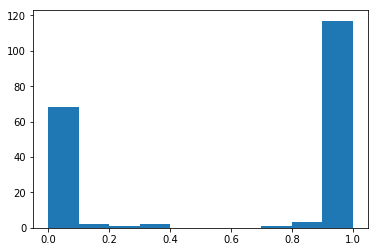

In [354]:
plt.hist(test['y'])

In [356]:
test.to_csv('nn_answer.csv', index=False)